# IEEE-CIS Fraud Detection
Can you detect fraud from customer transactions?


## Data Description
In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

### Categorical Features - Transaction
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

### Categorical Features - Identity
- DeviceType
- DeviceInfo
- id_12 - id_38


The `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp).


### Files
- `train_{transaction, identity}.csv` - the training set
- `test_{transaction, identity}.csv` - the test set (you must predict the isFraud value for these observations)


### Evaluation Metric
- Submissions are evaluated on area under the `ROC` curve between the predicted probability and the observed target. For each `TransactionID` in the test set, you must predict a probability for the `isFraud` variable.

In [0]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

# Configure visualisations
%matplotlib inline
plt.style.use('ggplot')

# Configure seaborn
sns.set_style('white')
sns.set_style('white',{"xtick.major.size": 5, "ytick.major.size": 5})

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 15

import warnings
warnings.filterwarnings('ignore')


## Datasets
Data is separated into two datasets: information about the identity of the customer and transaction information. bold text
- **train_transaction** : contains **590,540** rows and **394** features.
- **train_identity**: contains **144,233** rows and **41** features.

In [0]:
folder_path = '/content/drive/My Drive/IEEE-CIS Fraud Detection/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')

In [0]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


## Data Type

In [0]:
def count_feature_type(df):
    return df.dtypes.value_counts()

print("Train transaction\n", count_feature_type(train_transaction) ,"\n")
print("Train identity\n",count_feature_type(train_identity))

Train transaction
 float64    376
object      14
int64        4
dtype: int64 

Train identity
 float64    23
object     17
int64       1
dtype: int64


After importing the dataset of train transaction and identity data then combine them in to one. Merging of both identity data and transaction data will be done through TransactionID column because it is common in both the files.

In [0]:
# Let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [0]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


So we have two medium-sized datasets with a lot of columns. 

## Features and variables
- **TransactionDT**: timedelta from a given reference datetime (not a timestamp)
- **TransactionAMT**: transaction payment in USD
- **ProductCD**: product code, the product for each transaction
- **card1-card6**: payment card information, such as card type
- **addr1-addr2:**:  billing region and billing country
- **dist1-dist2**: distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.
- **P_ and (R_)emaildomain**: purchaser and recipient email domain, some of the transactions do not require a recipient, and the corresponding Remaildomain is empty.
- **C1-C14**: counting, addresses and other things, actual meaning masked
- **D1-D15**: timedelta, such as days between previous transaction, etc
- **M1-M9**: match, such as names on card and address, etc
- **V1-V339**: Vesta engineered rich features, including ranking, counting, and other entity relations different Some of the V features have different proportions of missing, and their true meaning and treatment are still unknown.

In [0]:
# List of all column names
#print(train_transaction.columns.values)
#print(test_transaction.columns.values)

In [0]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  ...  V337 V338  V339
0        2987000        0          86400  ...   NaN  NaN   NaN
1        2987001        0          86401  ...   NaN  NaN   NaN
2        2987002        0          86469  ...   NaN  NaN   NaN
3        2987003        0          86499  ...   NaN  NaN   NaN
4        2987004        0          86506  ...   0.0  0.0   0.0

[5 rows x 394 columns]

 There are a lot of **NaN**

In [0]:
train_identity.head()

TransactionID  id_01  ...  DeviceType                     DeviceInfo
0        2987004    0.0  ...      mobile  SAMSUNG SM-G892A Build/NRD90M
1        2987008   -5.0  ...      mobile                     iOS Device
2        2987010   -5.0  ...     desktop                        Windows
3        2987011   -5.0  ...     desktop                            NaN
4        2987016    0.0  ...     desktop                          MacOS

[5 rows x 41 columns]

In [0]:
# Text Annotation
def text_annotate(cnt):
    for i in cnt.patches:
        height = i.get_height()
        cnt.text(i.get_x() + i.get_width()/2., height,'%d' % int(height),ha='center',va='bottom')

#-------------------------------------------------------------------------------------------------

def get_stats(fraud):
    return {'No Fraud':fraud.count()-fraud.sum(),'Fraud': fraud.sum(),'All': fraud.count(),
            'Fraud(%)':'{:.2f}%'.format(fraud.mean()*100)}

# --------------------------------------------------------------------

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

# --------------------------------------------------------------------

def h(content):
    display(HTML(content))
# --------------------------------------------------------------------

def corr(col):
    N = None #10000
    num_vars = [f for f in train.columns if train[f].dtype != 'object']
    trx = train.head(N) if N is not None else train.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))

included_cols = list(train.columns.values[:20])

# --------------------------------------------------------------------

train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
def ploting_cnt_amt(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{Column} Distributions ', fontsize=24)
    
    plt.subplot(211)
    plot_1 = sns.countplot(x=Column,data=DataFile,order=list(tmp[Column].values), palette='Blues')
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='gray', legend=False)
    plot_1_2.set_ylim(0,tmp['Fraud'].max()*1.1)
    plot_1_2.set_ylabel("%Fraud Transactions", fontsize=16)
    plot_1.set_title(f"Most Frequent {Column} values and % Fraud Transactions", fontsize=20)
    plot_1.set_xlabel(f"{Column} Category", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    plot_1.set_xticklabels(plot_1.get_xticklabels(),rotation=45)
    sizes = []
    for p in plot_1.patches:
        height = p.get_height()
        sizes.append(height)
        plot_1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    plot_1.set_ylim(0,max(sizes)*1.15)
    
    perc_amt = (DataFile.groupby(['isFraud',Column])['TransactionAmt'].sum() \
                / DataFile.groupby([Column])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = DataFile.groupby([Column])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    plot_2 = sns.barplot(x=Column, y='TransactionAmt', 
                       data=amt, palette='Blues',
                       order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, 
                        order=list(tmp[Column].values),
                       color='gray', legend=False, )
    plot_2_2.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)
    plot_2.set_title(f"{Column} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    plot_2.set_xlabel(f"{Column} Category ", fontsize=16)
    plot_2.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)    
    
    for p in plot_2.patches:
        height = p.get_height()
        plot_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

# --------------------------------------------------------------------

def describe(datatrain,datatest,feature):
    d = pd.DataFrame(columns=[feature,'Train','TrainFraud','TrainNoFraud','Test'])
    d[feature] = ['count','mean','std','min','25%','50%','75%','max','unique','NaN','NaNshare']
    for i in range(0,8):
        d['Train'].iloc[i] = datatrain[feature].describe().iloc[i]
        d['TrainFraud'].iloc[i]=datatrain[datatrain['isFraud']==1][feature].describe().iloc[i]
        d['TrainNoFraud'].iloc[i]=datatrain[datatrain['isFraud']==0][feature].describe().iloc[i]
        d['Test'].iloc[i]=datatest[feature].describe().iloc[i]
    d['Train'].iloc[8] = len(datatrain[feature].unique())
    d['TrainFraud'].iloc[8]=len(datatrain[datatrain['isFraud']==1][feature].unique())
    d['TrainNoFraud'].iloc[8]=len(datatrain[datatrain['isFraud']==0][feature].unique())
    d['Test'].iloc[8]=len(datatest[feature].unique())
    d['Train'].iloc[9] = datatrain[feature].isnull().sum()
    d['TrainFraud'].iloc[9] = datatrain[datatrain['isFraud']==1][feature].isnull().sum()
    d['TrainNoFraud'].iloc[9] = datatrain[datatrain['isFraud']==0][feature].isnull().sum()
    d['Test'].iloc[9]=datatest[feature].isnull().sum()
    d['Train'].iloc[10] = datatrain[feature].isnull().sum()/len(datatrain)
    d['TrainFraud'].iloc[10] = datatrain[datatrain['isFraud']==1][feature].isnull().sum()/len(datatrain[datatrain['isFraud']==1])
    d['TrainNoFraud'].iloc[10] = datatrain[datatrain['isFraud']==0][feature].isnull().sum()/len(datatrain[datatrain['isFraud']==0])
    d['Test'].iloc[10]=datatest[feature].isnull().sum()/len(datatest)
    return d

# --------------------------------------------------------------------

def compare_cate(df,colname,targetname):
    # caculate aggregate stats
    df_cate = df.groupby([colname])[targetname].agg(['count', 'sum','mean'])
    df_cate.reset_index(inplace=True)
    print(df_cate)
    
    # plot visuals
    f, ax = plt.subplots(figsize=(15, 6))
    ax.tick_params(axis='x',labelrotation=90)
    plt1 = sns.lineplot(x=colname, y="mean", data=df_cate,color="r")
    
    for tl in ax.get_yticklabels():
        tl.set_color('r')

    ax2 = ax.twinx()
    plt2 = sns.barplot(x=colname, y="count", data=df_cate, palette='Blues',
                       ax=ax2,alpha=0.5)

# --------------------------------------------------------------------

def plot_numerical(feature):
    """
    Plot some information about a numerical feature for both train and test set.
    Args:
        feature (str): name of the column in DataFrame
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
    sns.kdeplot(train[feature], ax=axes[0][0], label='Train', color='blue')
    sns.kdeplot(test[feature], ax=axes[0][0], label='Test', color='#87CEFA' )

    sns.kdeplot(train[train['isFraud']==0][feature], ax=axes[0][1], label='isFraud 0',color='#90EE90' )
    sns.kdeplot(train[train['isFraud']==1][feature], ax=axes[0][1], label='isFraud 1', color='#FA8072')

    test[feature].index += len(train)
    axes[1][0].plot(train[feature], '.', label='Train', color='blue')
    axes[1][0].plot(test[feature], '.', label='Test', color='#87CEFA')
    axes[1][0].set_xlabel('row index')
    axes[1][0].legend()
    test[feature].index -= len(train)

    axes[1][1].plot(train[train['isFraud']==0][feature], '.', label='isFraud 0', color='#90EE90')
    axes[1][1].plot(train[train['isFraud']==1][feature], '.', label='isFraud 1', color='#FA8072')
    axes[1][1].set_xlabel('row index');
    axes[1][1].legend()

    fig.suptitle(feature, fontsize=14);
    axes[0][0].set_title('Train/Test KDE distribution')
    axes[0][1].set_title('Target value KDE distribution')
    axes[1][0].set_title('Index versus value: Train/Test distribution')
    axes[1][1].set_title('Index versus value: Target distribution')
  

## Exploratory Data Analysis (EDA)



In [0]:
train.head(10)

TransactionID  isFraud  ...  DeviceType                     DeviceInfo
0        2987000        0  ...         NaN                            NaN
1        2987001        0  ...         NaN                            NaN
2        2987002        0  ...         NaN                            NaN
3        2987003        0  ...         NaN                            NaN
4        2987004        0  ...      mobile  SAMSUNG SM-G892A Build/NRD90M
5        2987005        0  ...         NaN                            NaN
6        2987006        0  ...         NaN                            NaN
7        2987007        0  ...         NaN                            NaN
8        2987008        0  ...      mobile                     iOS Device
9        2987009        0  ...         NaN                            NaN

[10 rows x 434 columns]

In [0]:
resumetable(train)[:50]

Dataset Shape: (590540, 434)


Name   dtypes  Missing  ...  Second Value  Third Value Entropy
0    TransactionID    int64        0  ...       2987001      2987002   19.17
1          isFraud    int64        0  ...             0            0    0.22
2    TransactionDT    int64        0  ...         86401        86469   19.11
3   TransactionAmt  float64        0  ...            29           59    8.35
4        ProductCD   object        0  ...             W            W    1.28
5            card1    int64        0  ...          2755         4663    9.97
6            card2  float64     8933  ...           404          490    6.32
7            card3  float64     1565  ...           150          150    0.68
8            card4   object     1577  ...    mastercard         visa    1.09
9            card5  float64     4259  ...           102          166    2.66
10           card6   object     1571  ...        credit        debit    0.82
11           addr1  float64    65706  ...           325          330    5.06
12           addr2  float64    65706  ...            87           87    0.08
13           dist1  float64   352271  ...           NaN          287    6.34
14           dist2  float64   552913  ...           NaN          NaN    7.42
15   P_emaildomain   object    94456  ...     gmail.com  outlook.com    2.68
16   R_emaildomain   object   453249  ...           NaN          NaN    2.76
17              C1  float64        0  ...             1            1    2.72
18              C2  float64        0  ...             1            1    2.75
19              C3  float64        0  ...             0            0    0.04
20              C4  float64        0  ...             0            0    1.12
21              C5  float64        0  ...             0            0    2.06
22              C6  float64        0  ...             1            1    2.52
23              C7  float64        0  ...             0            0    0.71
24              C8  float64        0  ...             0            0    1.25
25              C9  float64        0  ...             0            1    2.62
26             C10  float64        0  ...             0            0    1.23
27             C11  float64        0  ...             1            1    2.17
28             C12  float64        0  ...             0            0    0.95
29             C13  float64        0  ...             1            1    4.66
30             C14  float64        0  ...             1            1    2.67
31              D1  float64     1269  ...             0            0    5.57
32              D2  float64   280797  ...           NaN          NaN    8.57
33              D3  float64   262878  ...           NaN          NaN    5.60
34              D4  float64   168922  ...             0            0    6.42
35              D5  float64   309841  ...           NaN          NaN    5.95
36              D6  float64   517353  ...           NaN          NaN    4.09
37              D7  float64   551623  ...           NaN          NaN    4.29
38              D8  float64   515614  ...           NaN          NaN   11.32
39              D9  float64   515614  ...           NaN          NaN    4.29
40             D10  float64    76022  ...             0            0    6.09
41             D11  float64   279287  ...           NaN          315    6.73
42             D12  float64   525823  ...           NaN          NaN    3.70
43             D13  float64   528588  ...           NaN          NaN    2.26
44             D14  float64   528353  ...           NaN          NaN    3.14
45             D15  float64    89113  ...             0          315    6.88
46              M1   object   271100  ...           NaN            T    0.00
47              M2   object   271100  ...           NaN            T    0.49
48              M3   object   271100  ...           NaN            T    0.75
49              M4   object   281444  ...            M0           M0    1.31

[50 rows x 8 columns]

## Missing Value
First we will go through the amount of null values present in all the features and its data type.

In [0]:
# Let's see the number of null values present in each of the columns and the dtype of each column
for i in train.columns:
    print(i,'NaN values present is:',train[i].isnull().sum(),end=" ")
    print('Data type:',train[i].dtypes,end=" ")
    print(" % of Missing data = ", "%.2f%%" % (train[i].isnull().sum()/train.shape[0]*100))

TransactionID NaN values present is: 0 Data type: int64  % of Missing data =  0.00%
isFraud NaN values present is: 0 Data type: int64  % of Missing data =  0.00%
TransactionDT NaN values present is: 0 Data type: int64  % of Missing data =  0.00%
TransactionAmt NaN values present is: 0 Data type: float64  % of Missing data =  0.00%
ProductCD NaN values present is: 0 Data type: object  % of Missing data =  0.00%
card1 NaN values present is: 0 Data type: int64  % of Missing data =  0.00%
card2 NaN values present is: 8933 Data type: float64  % of Missing data =  1.51%
card3 NaN values present is: 1565 Data type: float64  % of Missing data =  0.27%
card4 NaN values present is: 1577 Data type: object  % of Missing data =  0.27%
card5 NaN values present is: 4259 Data type: float64  % of Missing data =  0.72%
card6 NaN values present is: 1571 Data type: object  % of Missing data =  0.27%
addr1 NaN values present is: 65706 Data type: float64  % of Missing data =  11.13%
addr2 NaN values present

In [0]:
# Sorted table for train missing value (%)
missingValue = pd.DataFrame(train.iloc[:,2:].isnull().sum(axis=0).sort_values(ascending=False),columns=['NaN'])
missingValue["Percentage"]= missingValue.NaN.apply(lambda x: '{:.2f}%'.format((float(x)/train.shape[0])*100))
missingValue[missingValue.NaN > 0].head(20) 

NaN Percentage
id_24  585793     99.20%
id_25  585408     99.13%
id_07  585385     99.13%
id_08  585385     99.13%
id_21  585381     99.13%
id_26  585377     99.13%
id_22  585371     99.12%
id_23  585371     99.12%
id_27  585371     99.12%
dist2  552913     93.63%
D7     551623     93.41%
id_18  545427     92.36%
D13    528588     89.51%
D14    528353     89.47%
D12    525823     89.04%
id_04  524216     88.77%
id_03  524216     88.77%
D6     517353     87.61%
id_33  517251     87.59%
id_10  515614     87.31%

In [0]:
# train total missing value(%)
missing_values_count = train.isnull().sum()
total_cells = np.product(train.shape)
print("train % of missing data = ", "%.2f%%" % (100 * missing_values_count.sum() / total_cells))

train % of missing data =  45.07%


## Distribution of Target variable (isFraud) in Training Set 

- Sparsity of the dataset
- Obviously this is a imbalanced classification problem. Only **~3.50%** of the total transactions were positively classified as fraud.



Notice how **imbalanced** is our original dataset. Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud.

**Imbalance** means that the number of data points available for different the classes is different

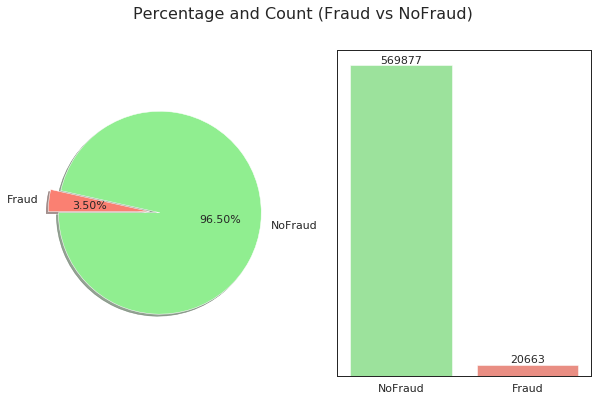

In [6]:
isFraud = {0:'No',1:'Yes'}

fig,axes=plt.subplots(1,2)
plt.suptitle('Percentage and Count (Fraud vs NoFraud)',fontsize=16)
labels = ['NoFraud', 'Fraud']
# Pie chart
train['isFraud'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%', ax=axes[0],
                                             labels=labels,colors=['#90EE90','#FA8072'], shadow=True, startangle=180)

axes[0].set_ylabel('')

# Bar chart
cnt = sns.countplot('isFraud', data=train, palette=['#90EE90', '#FA8072'], ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].set_xticklabels(labels)
text_annotate(cnt)
plt.show()

In [7]:
corr("isFraud")

## TransactionDT

One of the important features in this dataset is **TransactionDT**.This is a time related feature and the time is in second. 

The **TransactionDT** feature is a timedelta from a given reference datetime (not an actual timestamp). The train and test appear to be split by time. There is a slight gap in between, but otherwise the training set is from an earlier period of time and test is from a later period of time. This will impact which cross validation techniques should be used.

> The `TransactionDT` is the time (Not actual time but from a particular reference) in which the particular transaction happens. Since this data contains time (in sec) the train test split should be temporal, because 
the test data given in the kaggle have `TransactionDT` value larger than that of train means no overlap.

We will look into this more when reviewing differences in distribution of features between train and test.

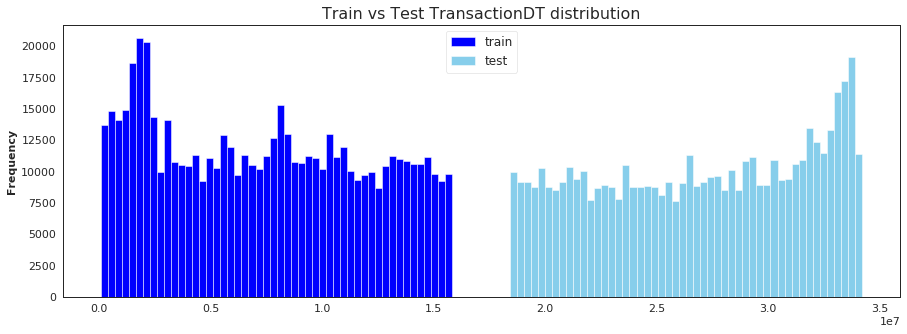

In [8]:
train['TransactionDT'].plot(kind='hist',figsize=(15, 5),label='train',bins=50,color='b',title='Train vs Test TransactionDT distribution')
test['TransactionDT'].plot(kind='hist',label='test',color='skyblue',bins=50)
plt.legend()
plt.show()

So lets transform TransactionDT into a datetime.

In [0]:
from time import time
import datetime
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

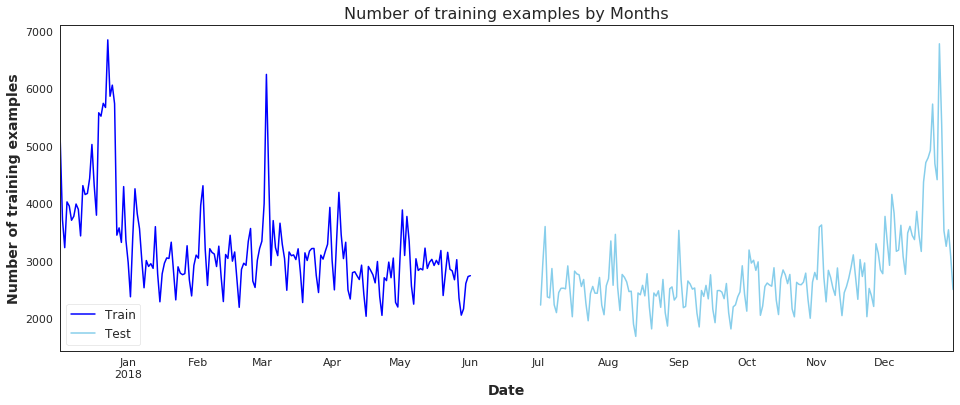

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=axes, color='b').set_xlabel('Date', fontsize=14)
test['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=axes, color='skyblue').set_ylabel('Number of training examples', fontsize=14)
axes.set_title('Number of training examples by Months', fontsize=16)
axes.legend(['Train', 'Test'])

- There's 30 days gap between test and train set.
- As we can see the test data that is given to us is ahead of train data time. So we will not do random split on data we will use temporal split. 
- From this feature we will *create 2 new features*. Since this is in sec, one feature will be in `day` and another feature will be in `hour`.

And now combining both mean of isFraud by day and number of training examples by day into a single plot.

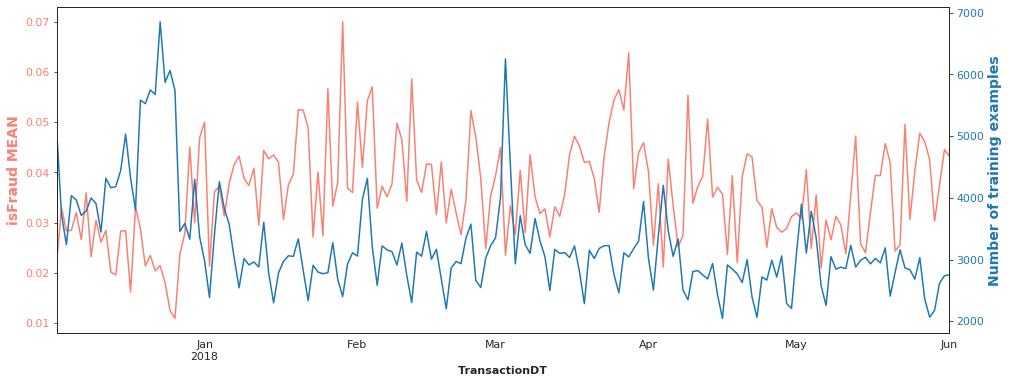

In [18]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='#FA8072')
ax1.tick_params(axis='y', labelcolor='#FA8072')
ax1.set_ylabel('isFraud MEAN', color='#FA8072', fontsize=14)
ax2 = ax1.twinx()
train['TransactionDT'].dt.floor('d').value_counts().sort_index().plot(ax=ax2, color='tab:blue');
ax2.tick_params(axis='y', labelcolor='tab:blue');
ax2.set_ylabel('Number of training examples', color='tab:blue', fontsize=14);
ax2.grid(False)

In [0]:
# Since we know transationDT is in sec we can create 2 new features from this hour and day

# creating day feature
train['day'] = (train['TransactionDT']//(3600*24)-1)%7
test['day'] = (test['TransactionDT']//(3600*24)-1)%7

# creating hour feature
train['hour'] = (train['TransactionDT']//(3600))%24
test['hour'] = (test['TransactionDT']//(3600))%24


Text(0.5, 1.0, 'Test')

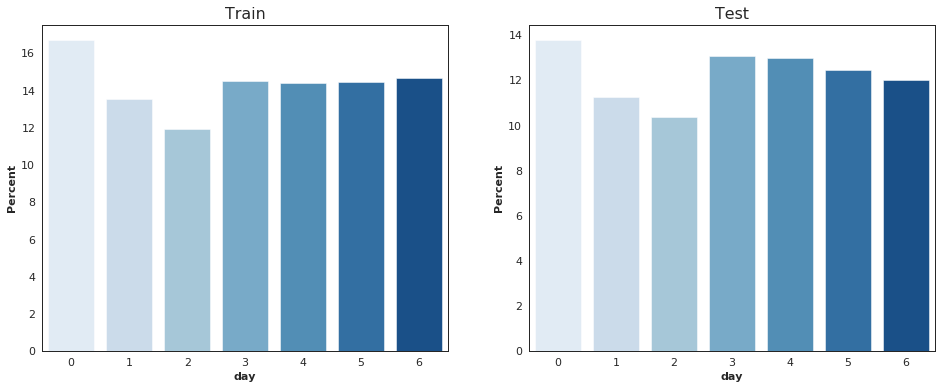

In [0]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
percentage = lambda i: len(i) / float(len(train['day'])) * 100
ax = sns.barplot(x=train['day'], y=train['day'],  estimator=percentage, palette='Blues')
ax.set(ylabel="Percent")
plt.title('Train')
plt.subplot(1,2,2)
percentage = lambda i: len(i) / float(len(train['day'])) * 100
ax = sns.barplot(x=test['day'], y=test['day'],  estimator=percentage, palette='Blues')
ax.set(ylabel="Percent")
plt.title('Test')

Day 0 has largest amount of transaction from all 6 days.

Text(0.5, 1.0, 'MEAN of isFraud by Month')

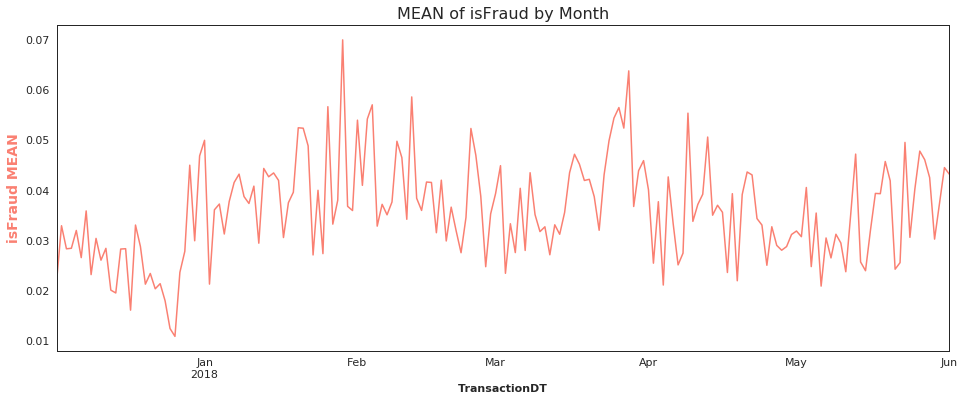

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=axes, color='#FA8072').set_ylabel('isFraud MEAN', fontsize=14, color='#FA8072')
axes.set_title('MEAN of isFraud by Month', fontsize=16)

In [0]:
train_day = (train.groupby(['isFraud'])['day']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('day'))

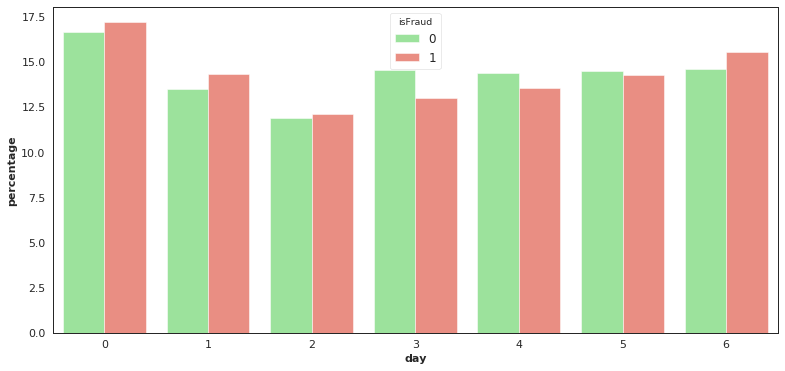

In [0]:
plt.figure(figsize=(13, 6))
sns.barplot(x="day", y="percentage", hue="isFraud", palette=['#90EE90', '#FA8072'], data=train_day)

In all the 7 days fraud and non-fraud transaction is happend in almost equal percentage

Text(0.5, 1.0, 'Test')

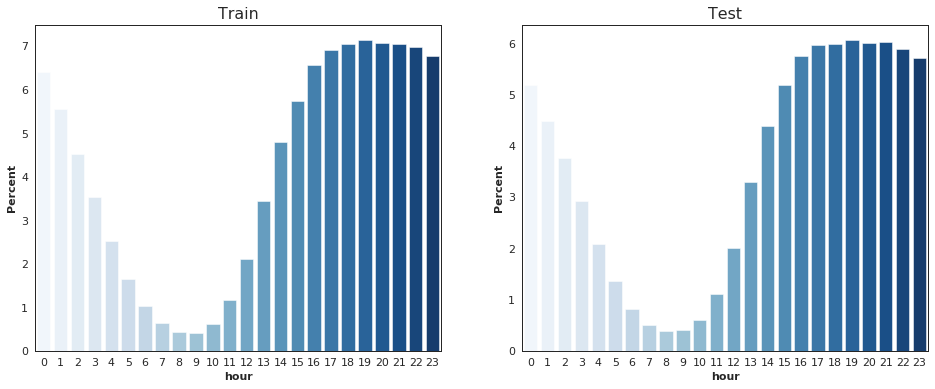

In [0]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
percentage = lambda i: len(i) / float(len(train['hour'])) * 100
ax = sns.barplot(x=train['hour'], y=train['hour'],  estimator=percentage, palette='Blues')
ax.set(ylabel="Percent")
plt.title('Train')
plt.subplot(1,2,2)
percentage = lambda i: len(i) / float(len(train['day'])) * 100
ax = sns.barplot(x=test['hour'], y=test['hour'],  estimator=percentage, palette='Blues')
ax.set(ylabel="Percent")
plt.title('Test')

From hour 0-9 the amount of transaction decreases then from 9 it increases again.

In [0]:
train_hour = (train.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))

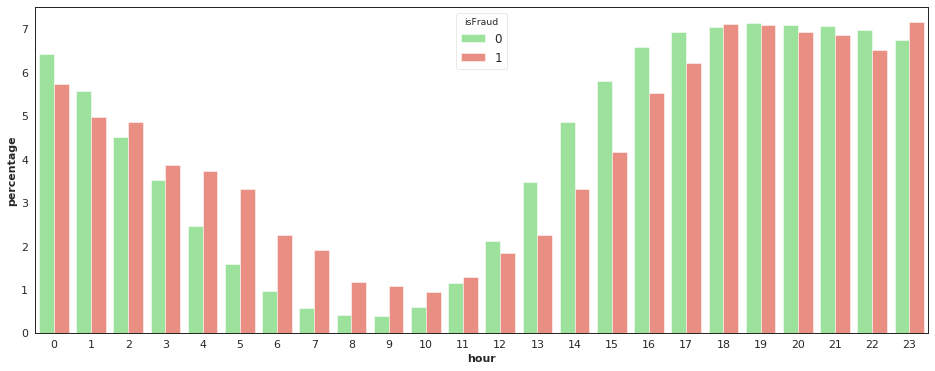

In [0]:
plt.figure(figsize=(16, 6))
sns.barplot(x="hour", y="percentage", hue="isFraud",palette=['#90EE90', '#FA8072'] , data=train_hour)

In [0]:
# New Features
def hourFeature(hour):
    if hour>3 and hour < 11:
        return "highalert"
    if hour ==11 or hour==18:
        return "lowalert"
    if hour==2 or hour==3 or hour==23:
        return "mediumalert"
    else:
        return "noalert"

In [0]:
train['alertFeature'] = train['hour'].apply(hourFeature)
test['alertFeature'] = test['hour'].apply(hourFeature)

From the plot it is confirm that the hour from 4 to 9 rate of fraud transaction is more and from 9 to 18 rate of non-fraud transaction is more.

In [0]:
# Analysis on TransactionDT of both train and test
transactionDTDescribe = describe(train,test,'TransactionDT')
transactionDTDescribe

TransactionDT        Train   TrainFraud TrainNoFraud         Test
0          count       590540        20663       569877       506691
1           mean  7.37231e+06  7.69003e+06  7.36079e+06  2.69299e+07
2            std  4.61722e+06  4.41655e+06  4.62393e+06  4.75651e+06
3            min        86400        89760        86400  1.84032e+07
4            25%  3.02706e+06  3.96586e+06  3.01065e+06  2.27715e+07
5            50%  7.30653e+06  7.57523e+06  7.27168e+06  2.72047e+07
6            75%  1.12466e+07  1.12174e+07  1.12533e+07  3.13486e+07
7            max  1.58111e+07  1.58109e+07  1.58111e+07  3.42143e+07
8         unique       573349        20638       553717       494686
9            NaN            0            0            0            0
10      NaNshare            0            0            0            0

In [0]:
corr('TransactionDT')

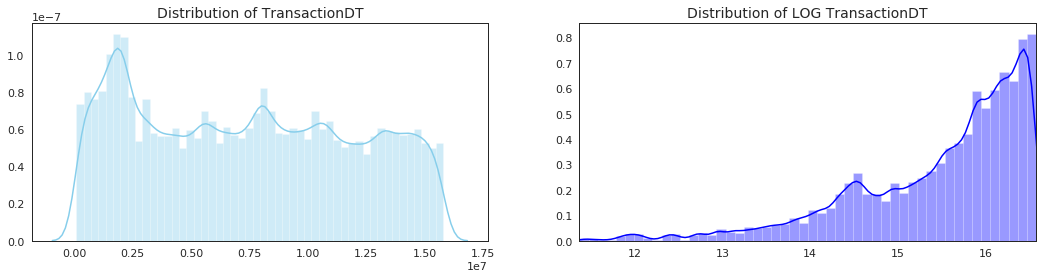

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

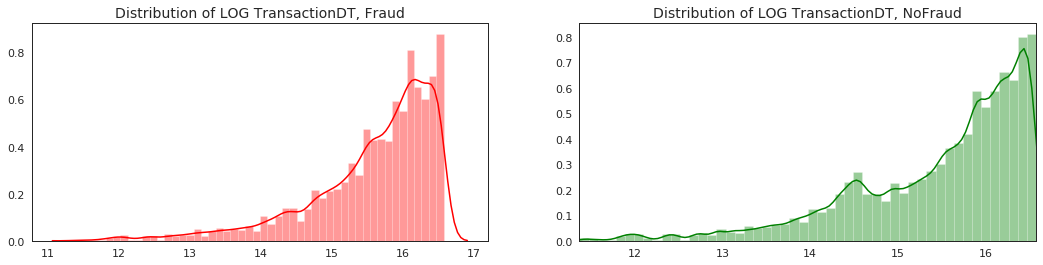

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train.loc[train['isFraud'] == 1]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionDT, Fraud', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train.loc[train['isFraud'] == 0]['TransactionDT'].values

sns.distplot(np.log(time_val), ax=ax[1], color='g')
ax[1].set_title('Distribution of LOG TransactionDT, NoFraud', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

## Transaction Amount Values Distribution (TransactionAmt)
Another important feature in this dataset is **TransactionAmt**. Let first try to understand the details about this feature in both train and test dataset.

> Is clear that no null(NaN) values present in both train and test dataset. But one interesting observation is that upto `75%` values are below 125 but suddenly it rises to around 32,000 in train and 10,000 in test.
- Max value of `train transactionAmt` is much more than the `test transactionAmt`.
- May be some of `outliers` are there in the train data 

In [0]:
# Analysis on TransactionAmt of both train and test
transactionAmtDescribe = describe(train,test,'TransactionAmt')  
transactionAmtDescribe

TransactionAmt    Train TrainFraud TrainNoFraud     Test
0           count   590540      20663       569877   506691
1            mean  135.027    149.245      134.512  134.726
2             std  239.163    232.212      239.395   245.78
3             min    0.251      0.292        0.251    0.018
4             25%   43.321     35.044        43.97       40
5             50%   68.769         75         68.5    67.95
6             75%      125        161          120      125
7             max  31937.4       5191      31937.4    10270
8          unique    20902       2515        20560    14119
9             NaN        0          0            0        0
10       NaNshare        0          0            0        0

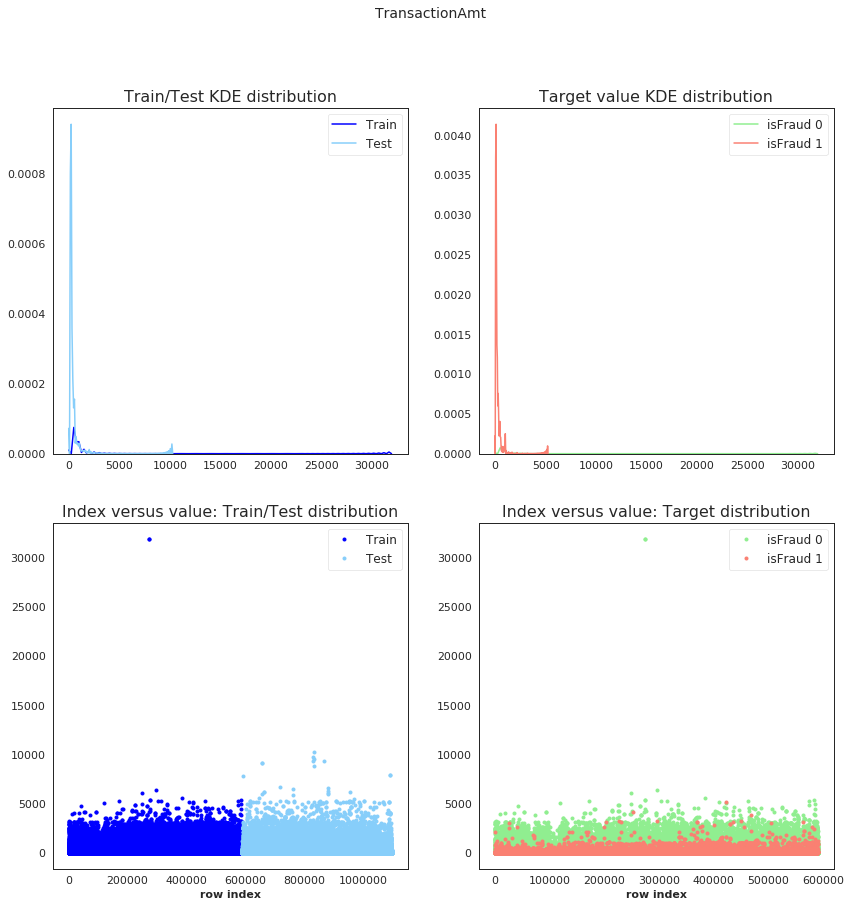

In [5]:
plot_numerical('TransactionAmt')

Moving average for `TransactionAmt` over time.

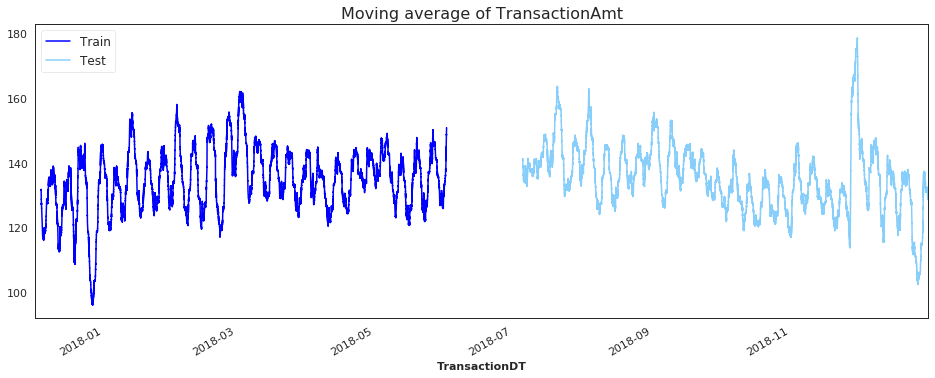

In [50]:
fig, axes = plt.subplots(1,1,figsize=(16, 6))
axes.set_title('Moving average of TransactionAmt', fontsize=16)
train[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').rolling(10000).mean().plot(ax=axes, color='blue' )
test[['TransactionDT', 'TransactionAmt']].set_index('TransactionDT').rolling(10000).mean().plot(ax=axes, color='#87CEFA')
axes.legend(['Train', 'Test'])

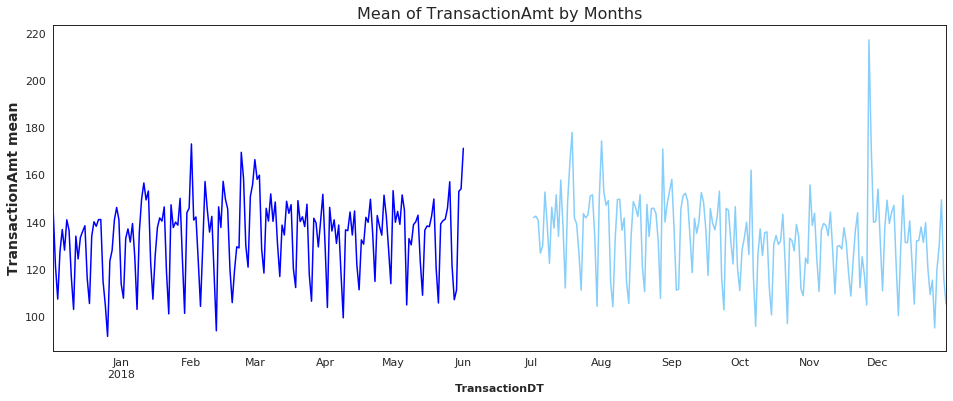

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=axes, color='blue').set_ylabel('TransactionAmt mean', fontsize=14);
test.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=axes, color='#87CEFA').set_ylabel('TransactionAmt mean', fontsize=14);
axes.set_title('Mean of TransactionAmt by Months', fontsize=16);

A relationship between mean of TransactionAmt by day and a mean of isFraud by day.

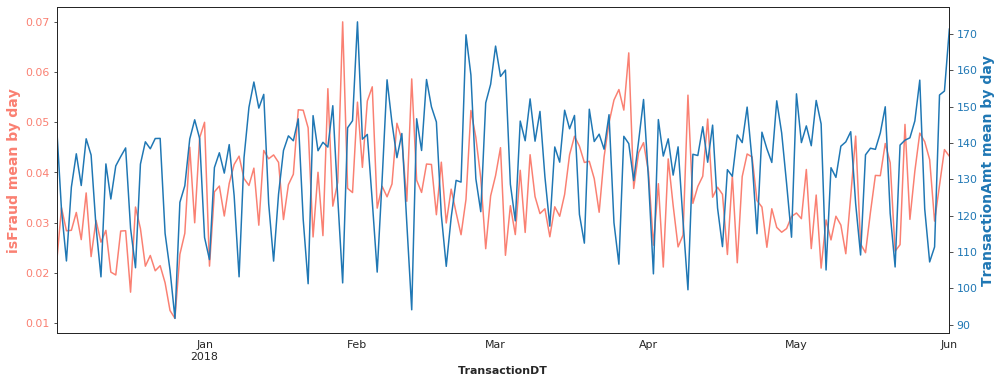

In [54]:
fig, ax1 = plt.subplots(figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=ax1, color='#FA8072')
ax1.tick_params(axis='y', labelcolor='#FA8072')
ax1.set_ylabel('isFraud mean by day', color='#FA8072', fontsize=14)
ax2 = ax1.twinx()
train.set_index('TransactionDT').resample('D').mean()['TransactionAmt'].plot(ax=ax2, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue');
ax2.set_ylabel('TransactionAmt mean by day', color='tab:blue', fontsize=14);
ax2.grid(False)

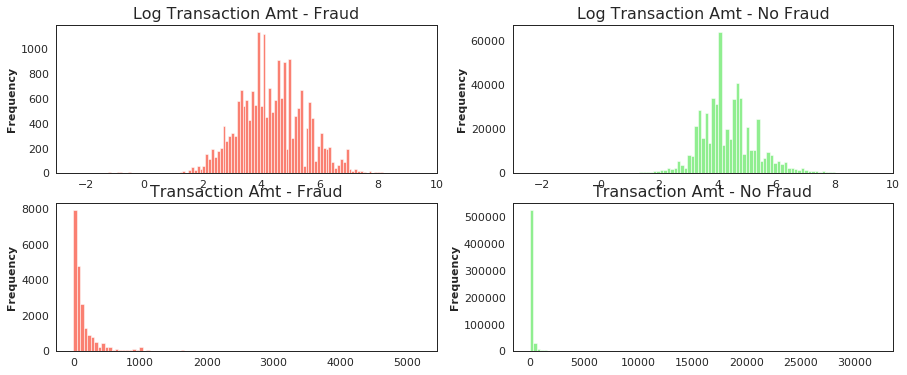

In [0]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] ['TransactionAmt'].apply(np.log).plot(kind='hist',
                                                                       bins=100,
                                                                       title='Log Transaction Amt - Fraud',
                                                                       color='#FA8072',
                                                                       xlim=(-3, 10),
                                                                       ax= ax1)
train.loc[train['isFraud'] == 0]['TransactionAmt'].apply(np.log).plot(kind='hist',
                                                                      bins=100,
                                                                      title='Log Transaction Amt - No Fraud',
                                                                      color='#90EE90',
                                                                      xlim=(-3, 10),
                                                                      ax=ax2)
train.loc[train['isFraud'] == 1]['TransactionAmt'].plot(kind='hist',
                                                        bins=100,
                                                        title='Transaction Amt - Fraud',
                                                        color='#FA8072',
                                                        ax= ax3)
train.loc[train['isFraud'] == 0]['TransactionAmt'].plot(kind='hist',
                                                        bins=100,
                                                        title='Transaction Amt - No Fraud',
                                                        color='#90EE90',
                                                        ax=ax4)
plt.show()

In [0]:
corr('TransactionAmt')

In [0]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train['Weekdays'] = train['Date'].dt.dayofweek
train['Hours'] = train['Date'].dt.hour
train['Days'] = train['Date'].dt.day

##Top Days with highest Total Transaction Amount

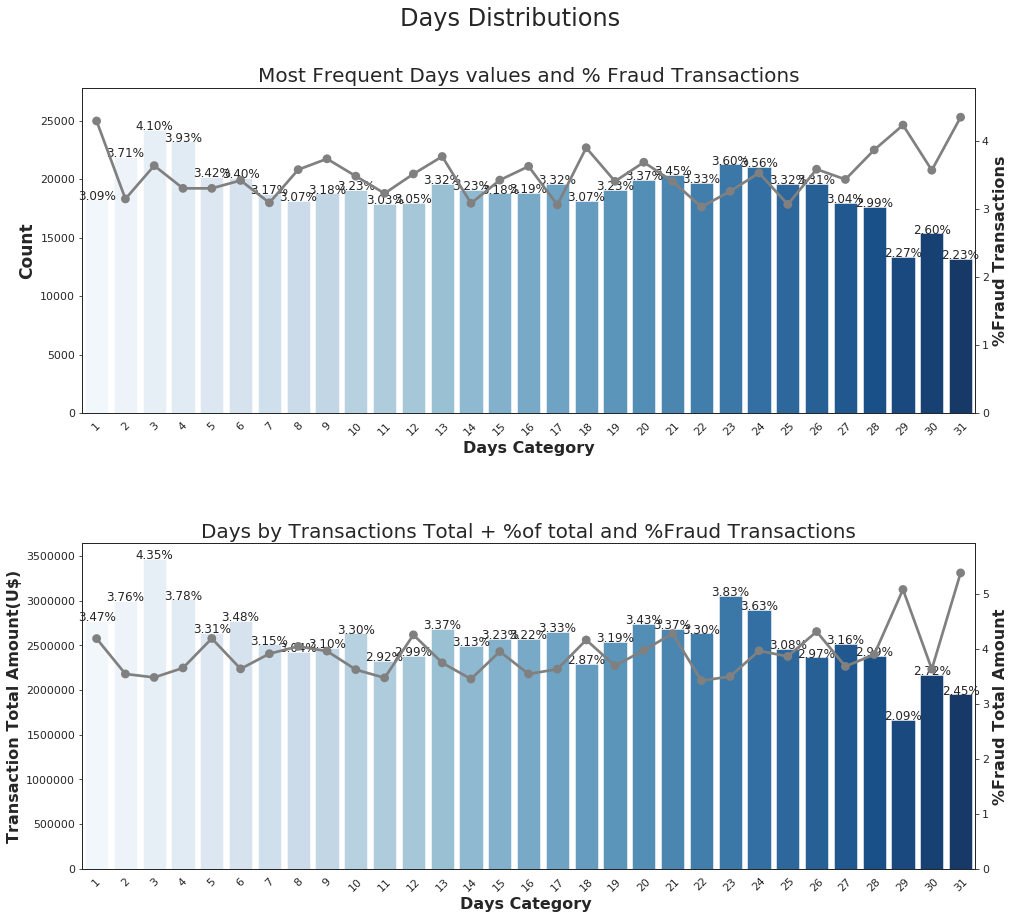

In [0]:
ploting_cnt_amt(train, 'Days')

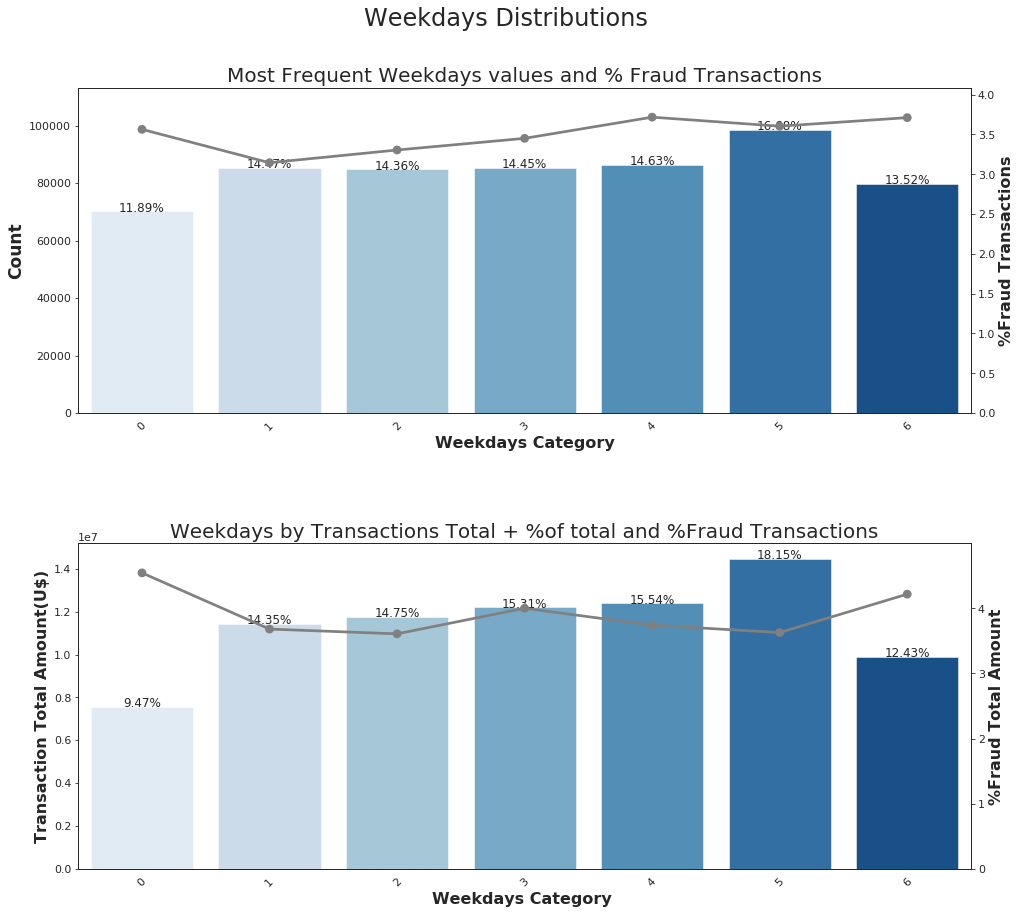

In [0]:
ploting_cnt_amt(train, 'Weekdays')

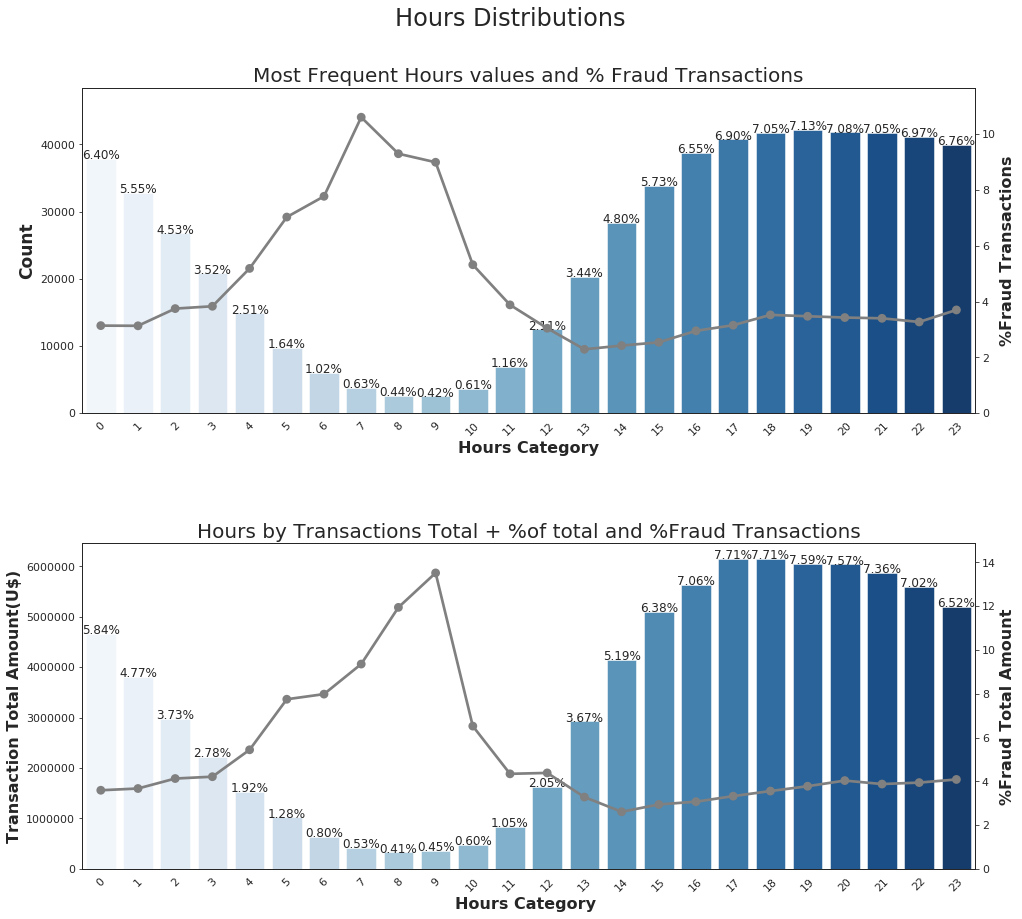

In [0]:
ploting_cnt_amt(train, 'Hours')

- Around 7,8,9 and 10 hours we can see that there's a daily spike in the  amount of fraud indicated by the gray line.

In [0]:
print('Mean transaction amt for fraud is {:.4f}'.format(train.loc[train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train.loc[train['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non-fraud is 134.5117


In [0]:
# Lets see using the threshold 10000 above
train[train['TransactionAmt']>10000]

TransactionID  isFraud  TransactionDT  ...  Weekdays Hours  Days
274336        3261336        0        6652360  ...         3    23    15
274339        3261339        0        6652391  ...         3    23    15

[2 rows x 441 columns]

Only 2 values which have higher than 10,000 and these 2 values seems like duplicate. Lets remove these 2 values.

In [0]:
train = train[train['TransactionAmt']<10000]

Text(0.5, 1.0, 'Test')

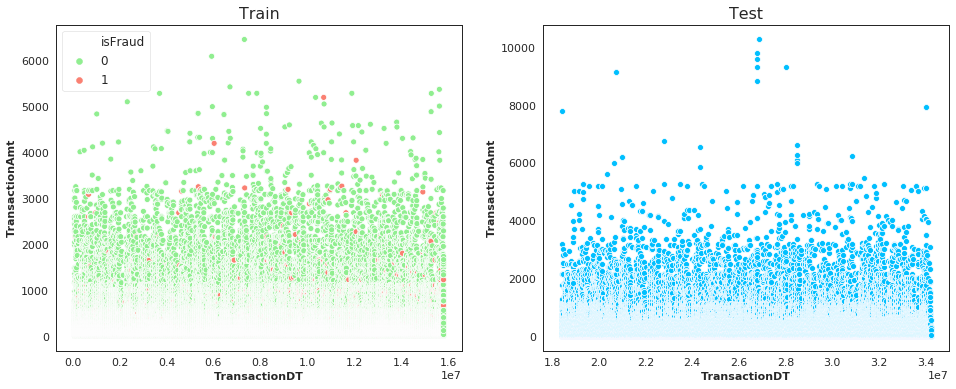

In [0]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="TransactionAmt",hue="isFraud",palette=['#90EE90', '#FA8072'], data=train)
plt.title('Train')

plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="TransactionAmt", color='#00BFFF', data=test)
plt.title('Test')

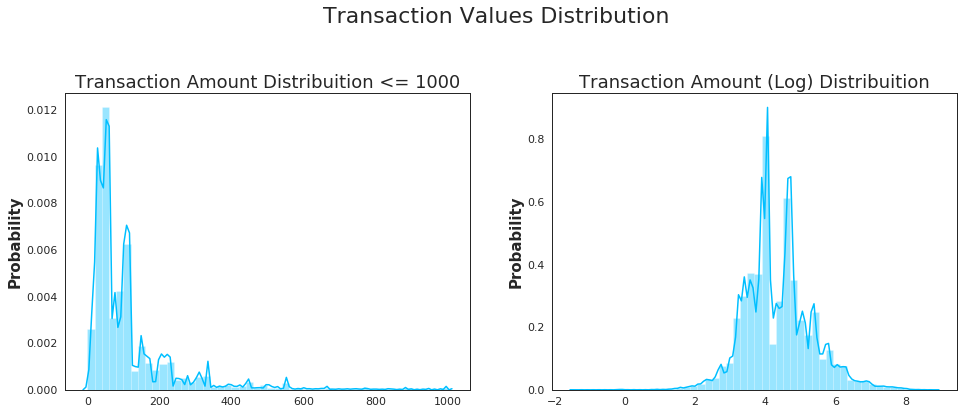

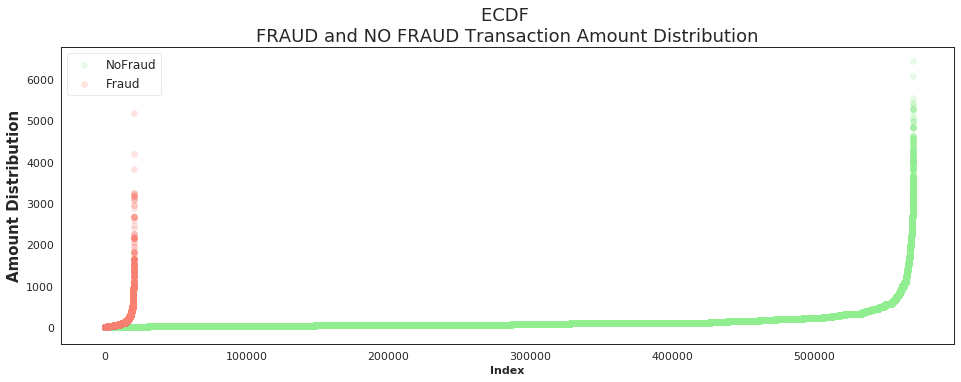

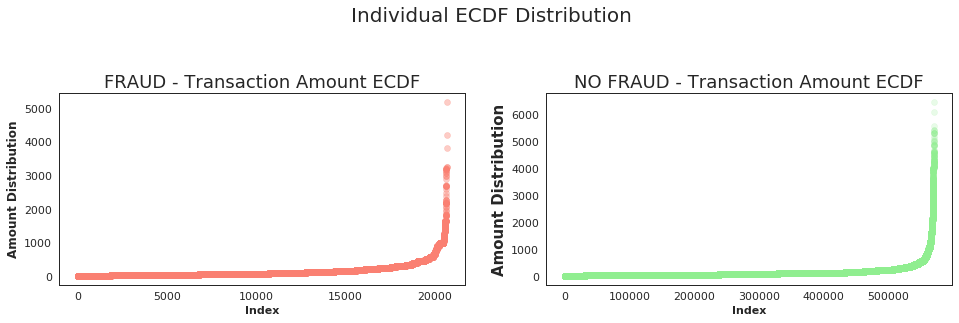

In [0]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train[train['TransactionAmt'] <= 1000]['TransactionAmt'], color='#00BFFF')
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train['TransactionAmt']),color='#00BFFF')
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
sub_plot_3 = plt.scatter(range(train[train['isFraud'] == 0].shape[0]),
                 np.sort(train[train['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2, color='#90EE90')
sub_plot_3 = plt.scatter(range(train[train['isFraud'] == 1].shape[0]),
                 np.sort(train[train['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2, color='#FA8072')
sub_plot_3= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train[train['isFraud'] == 1].shape[0]), 
                 np.sort(train[train['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4, color='#FA8072')
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train[train['isFraud'] == 0].shape[0]),
                 np.sort(train[train['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2, color='#90EE90')
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)

plt.show()

# Categorical Features - Transaction¶
The data description that the following transaction columns are categorical:

- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

## ProductCD 
product code, the product for each transaction and five category of products. And type **'W'** is the marjority.

- **W** has the most number of observations


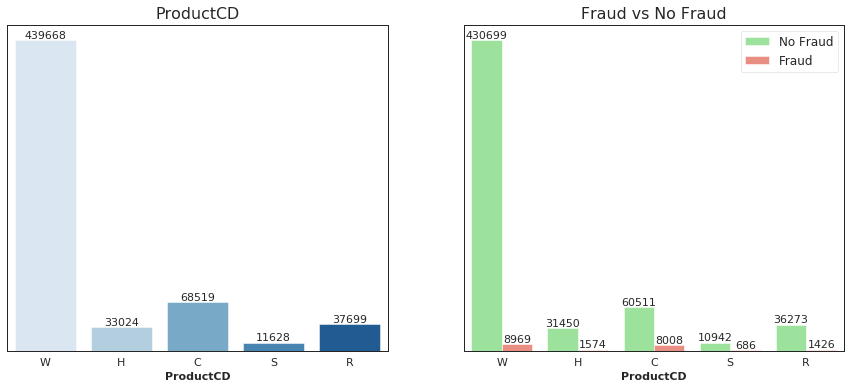

In [0]:
f,ax=plt.subplots(1,2, figsize=(15,6))
cnt= sns.countplot('ProductCD',palette='Blues',data=train, ax=ax[0])
ax[0].set_title('ProductCD')
ax[0].set_ylabel('')
ax[0].set_yticklabels('')
text_annotate(cnt)

cnt2 = sns.countplot('ProductCD',hue='isFraud',palette=['#90EE90', '#FA8072'], data=train, ax=ax[1])
ax[1].set_title('Fraud vs No Fraud')
ax[1].legend(['No Fraud','Fraud'])
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
text_annotate(cnt2)

plt.show()

In [0]:
train['isFraud'].groupby(train['ProductCD']).apply(get_stats).unstack()

No Fraud Fraud     All Fraud(%)
ProductCD                                
C            60511  8008   68519   11.69%
H            31450  1574   33024    4.77%
R            36273  1426   37699    3.78%
S            10942   686   11628    5.90%
W           430699  8969  439668    2.04%

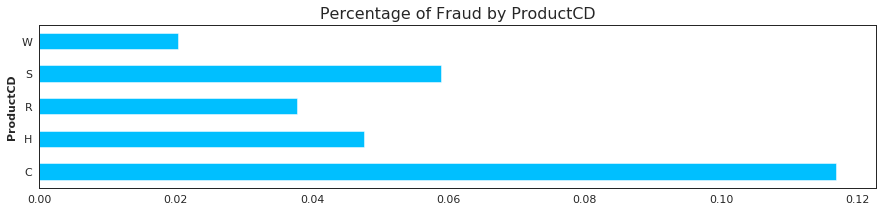

In [0]:
train.groupby('ProductCD')['isFraud'].mean().sort_index().plot(kind='barh',
                                                               color='#00BFFF',
                                                               figsize=(15, 3),
                                                               title='Percentage of Fraud by ProductCD')
plt.show()

- ProductCD C has the most fraud with >11%
- ProductCD W has the least with ~2%

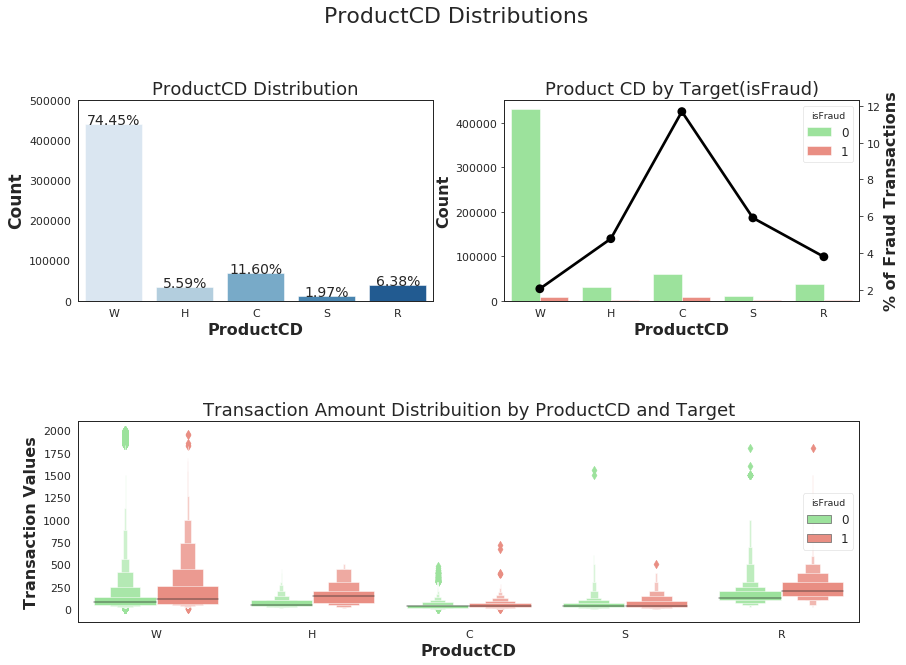

In [0]:
tmp = pd.crosstab(train['ProductCD'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='ProductCD', data=train, palette='Blues')

plot_1.set_title("ProductCD Distribution", fontsize=18)
plot_1.set_xlabel("ProductCD", fontsize=16)
plot_1.set_ylabel("Count", fontsize=17)
plot_1.set_ylim(0,500000)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='ProductCD', hue='isFraud',palette=['#90EE90', '#FA8072'], data=train)
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)

plot_2.set_title("Product CD by Target(isFraud)", fontsize=18)
plot_2.set_xlabel("ProductCD", fontsize=16)
plot_2.set_ylabel("Count", fontsize=16)

plt.subplot(212)
plot_3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', palette=['#90EE90', '#FA8072'],
              data=train[train['TransactionAmt'] <= 2000] )
plot_3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=18)
plot_3.set_xlabel("ProductCD", fontsize=16)
plot_3.set_ylabel("Transaction Values", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

Product type **W** and **R** has high mean TransactionAmt.

  ProductCD   count           sum        mean
0         C   68519  2.937571e+06   42.872353
1         H   33024  2.416368e+06   73.170058
2         R   37699  6.344975e+06  168.306188
3         S   11628  7.008136e+05   60.269487
4         W  439670  6.733922e+07  153.158554


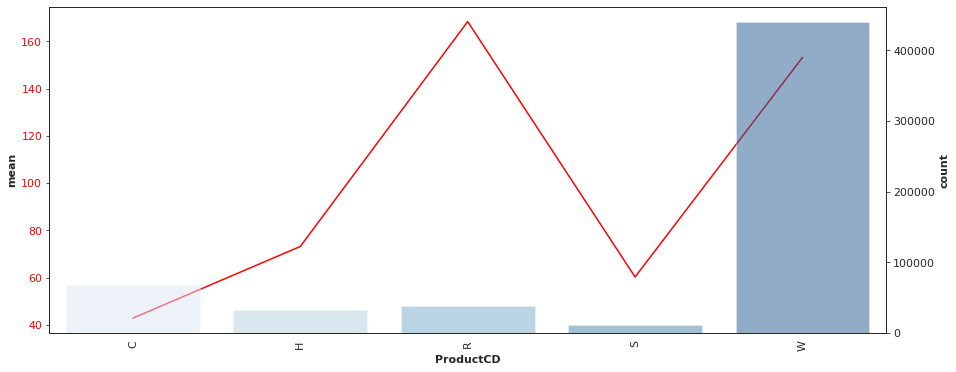

In [0]:
compare_cate(train_transaction,'ProductCD','TransactionAmt')

## Card Distributions

In [0]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit

## Card 1

Text(0.5, 1.0, 'Test')

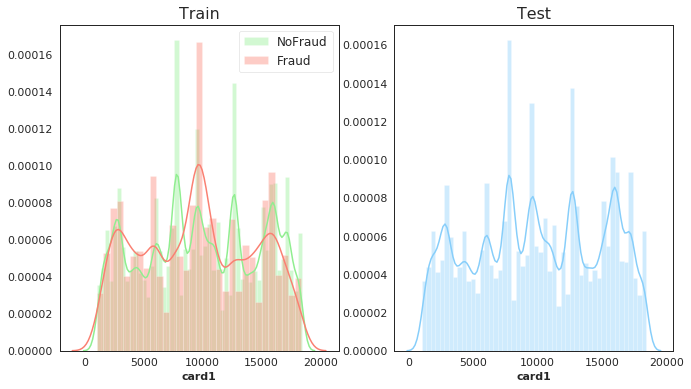

In [0]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[train['isFraud']==0]['card1'], color='#90EE90')
sns.distplot(train[train['isFraud']==1]['card1'], color='#FA8072')
plt.legend(['NoFraud','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test['card1'],color='#87CEFA')
plt.title('Test')

Plotting this Cards variable gives us such information as:

- Distribution in train and test set is almost equal.
- Distribution between target values differs, which make this feature so valuable

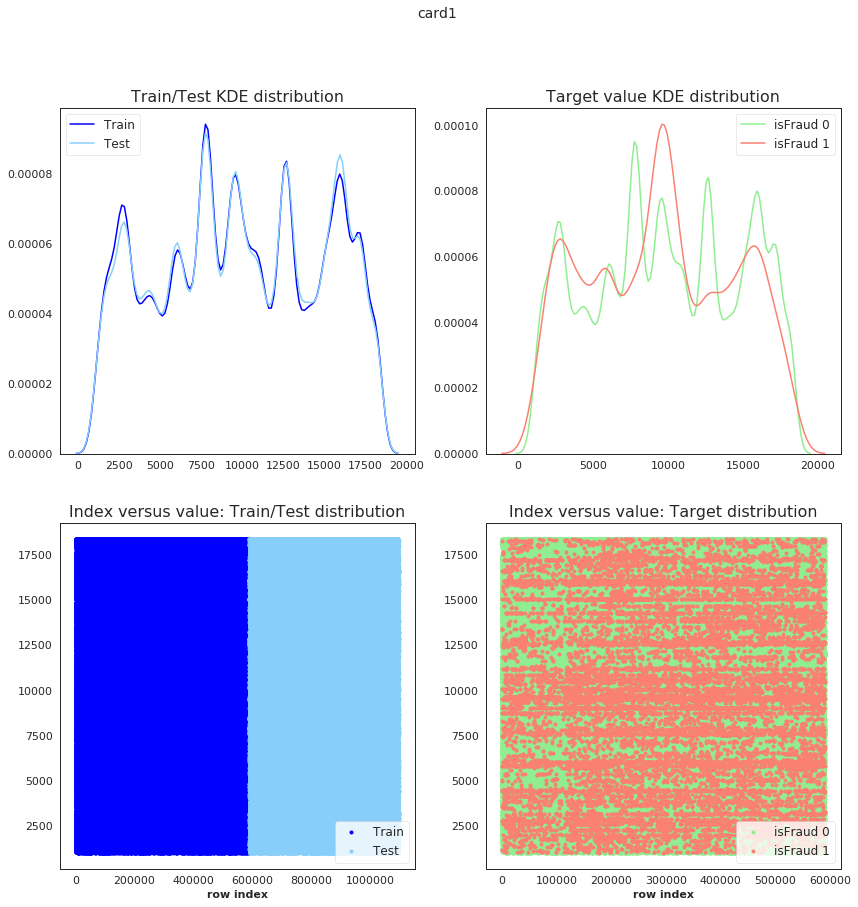

In [6]:
plot_numerical('card1')

## Card 2

Text(0.5, 1.0, 'Test')

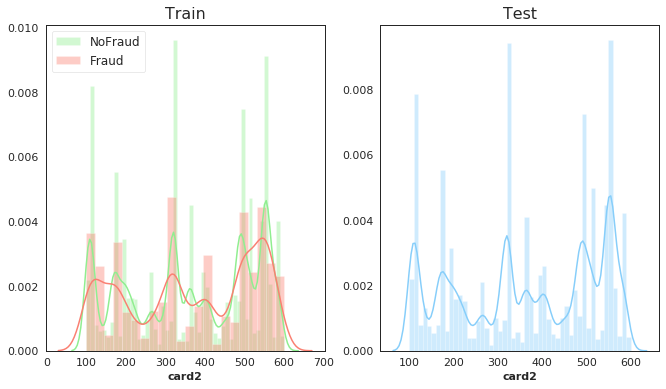

In [0]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['card2'].isnull())]['card2'], color='#90EE90')
sns.distplot(train[(train['isFraud']==1) & (~train['card2'].isnull())]['card2'], color='#FA8072')
plt.legend(['NoFraud','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['card2'].isnull()]['card2'],color='#87CEFA')
plt.title('Test')

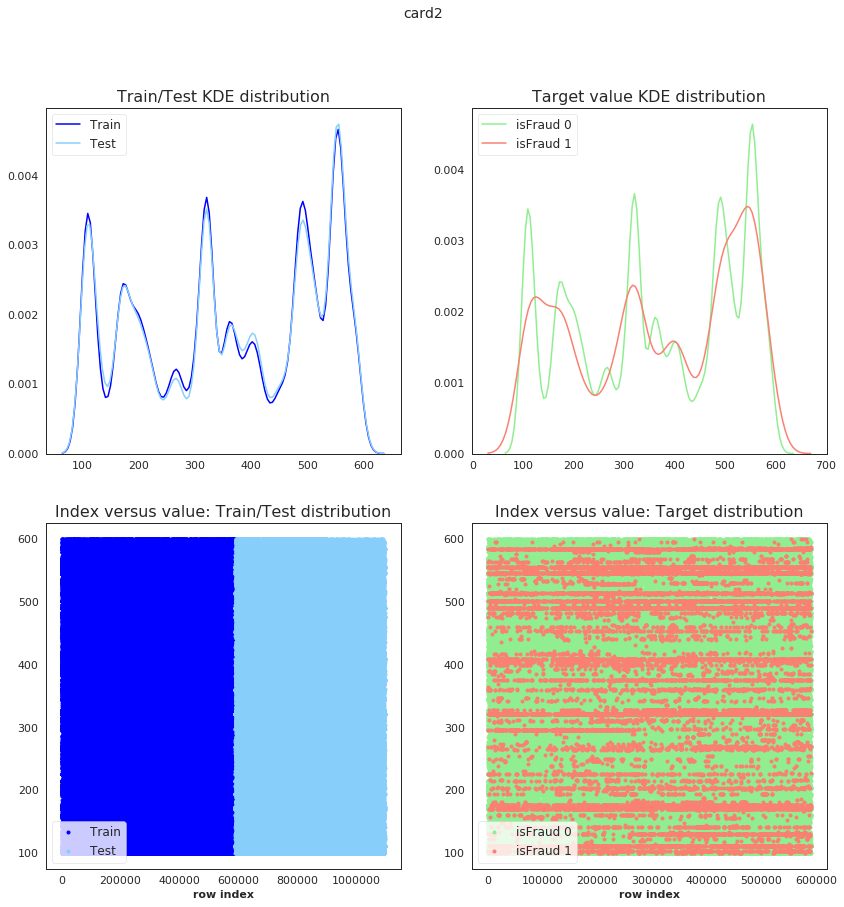

In [7]:
plot_numerical('card2')

Text(0.5, 1.0, 'Test')

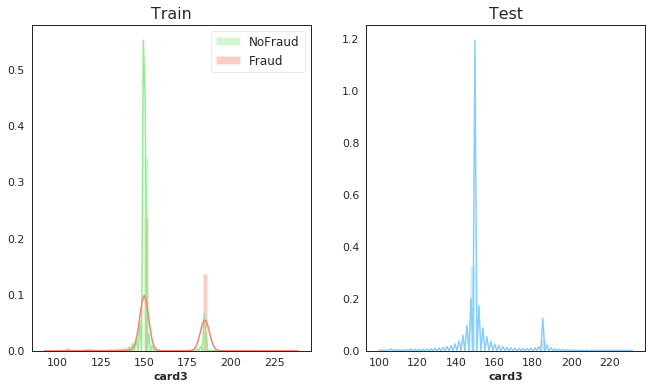

In [0]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['card3'].isnull())]['card3'], color='#90EE90')
sns.distplot(train[(train['isFraud']==1) & (~train['card3'].isnull())]['card3'], color='#FA8072')
plt.legend(['NoFraud','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['card3'].isnull()]['card3'],color='#87CEFA')
plt.title('Test')

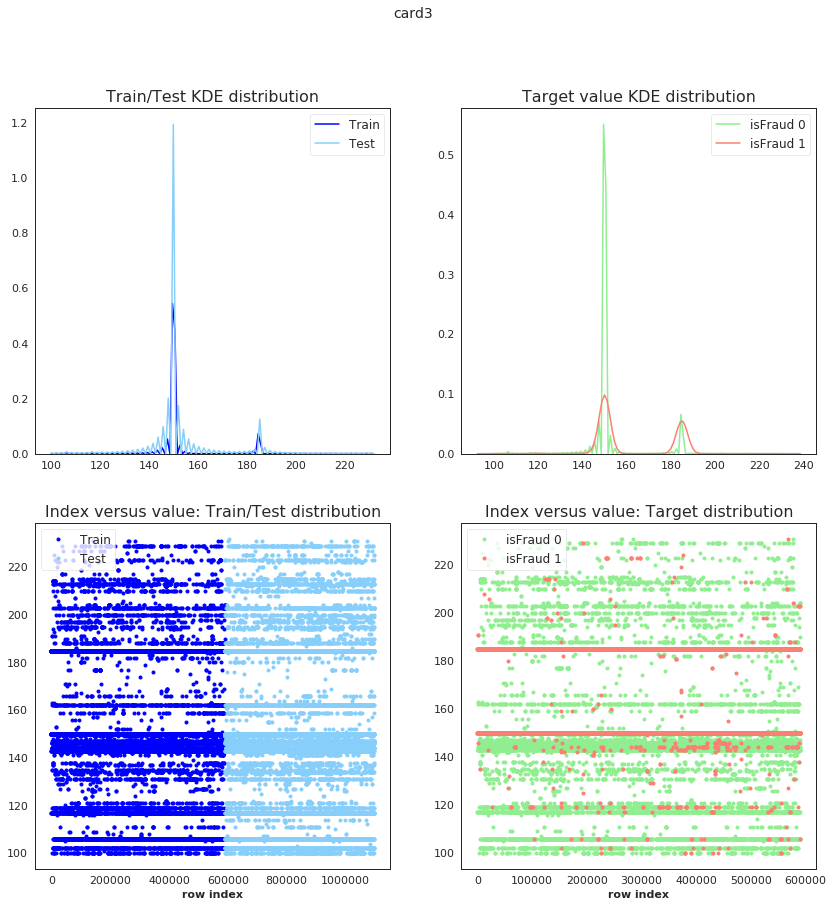

In [8]:
plot_numerical('card3')

### Card4 - Card Issue Bank

In [0]:
train['isFraud'].groupby(train['card4']).apply(get_stats).unstack().sort_values(by='Fraud(%)',ascending=False)

No Fraud  Fraud     All Fraud(%)
card4                                            
discover             6137    514    6651    7.73%
visa               371394  13373  384767    3.48%
mastercard         182719   6496  189215    3.43%
american express     8089    239    8328    2.87%

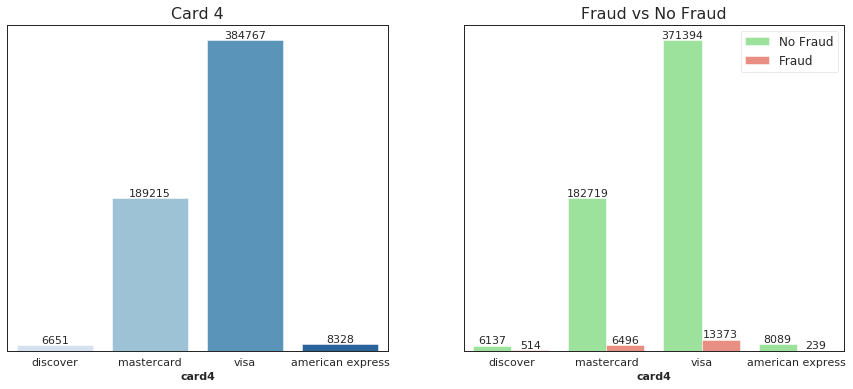

In [0]:
f,ax=plt.subplots(1,2, figsize=(15,6))
cnt= sns.countplot('card4',palette='Blues',data=train, ax=ax[0])
ax[0].set_title('Card 4')
ax[0].set_ylabel('')
ax[0].set_yticklabels('')
text_annotate(cnt)

cnt2 = sns.countplot('card4',hue='isFraud',palette=['#90EE90', '#FA8072'], data=train, ax=ax[1])
ax[1].set_title('Fraud vs No Fraud')
ax[1].legend(['No Fraud','Fraud'])
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
text_annotate(cnt2)

plt.show()

- Most of the transaction happend through visa card type.


              card4   count    sum      mean
0  american express    8328    239  0.028698
1          discover    6651    514  0.077282
2        mastercard  189215   6496  0.034331
3              visa  384767  13373  0.034756


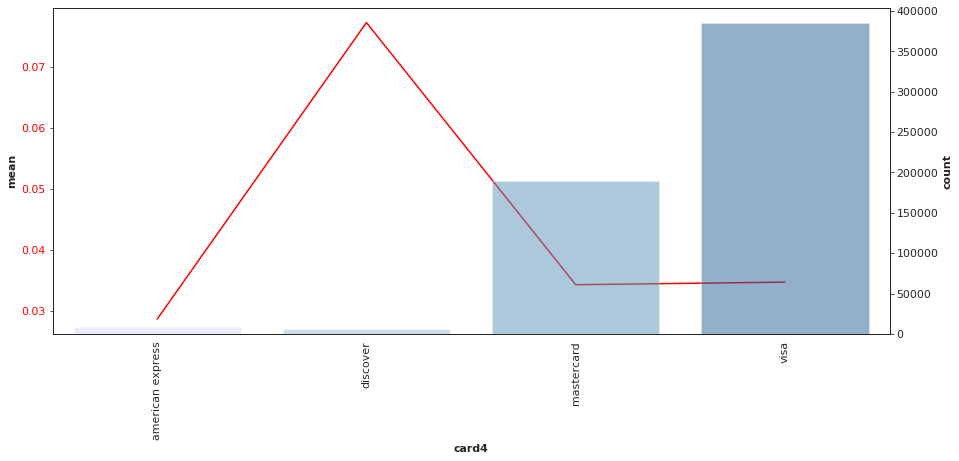

In [0]:
compare_cate(train,'card4','isFraud')

## Card 5

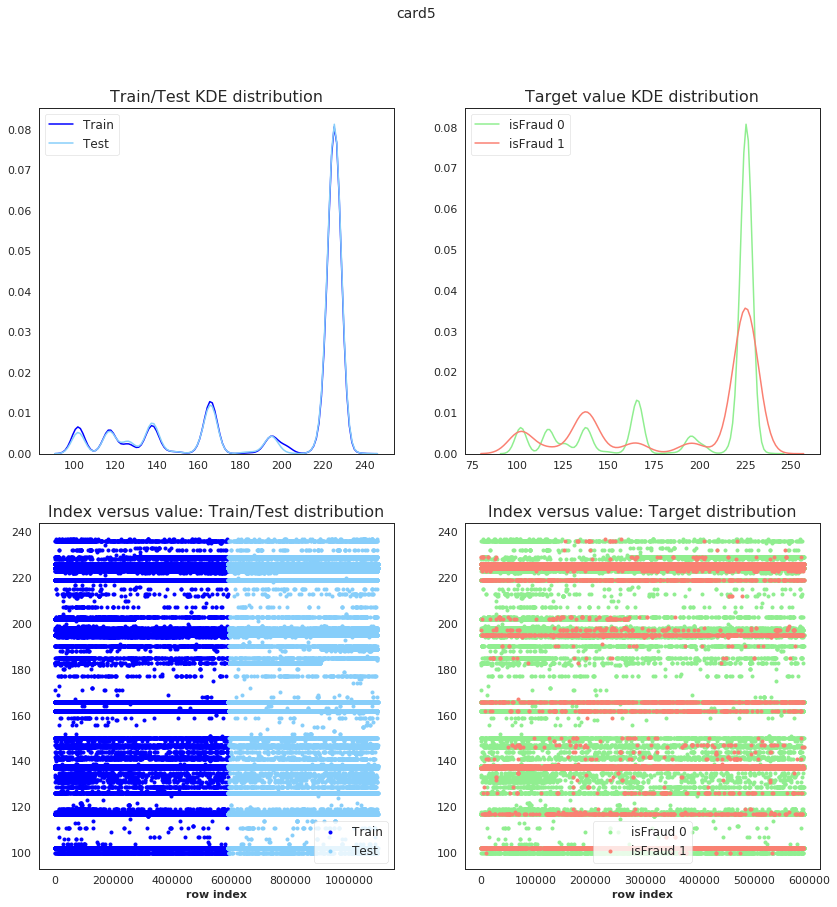

In [9]:
plot_numerical('card5')

### Card 6 - Type of Cards

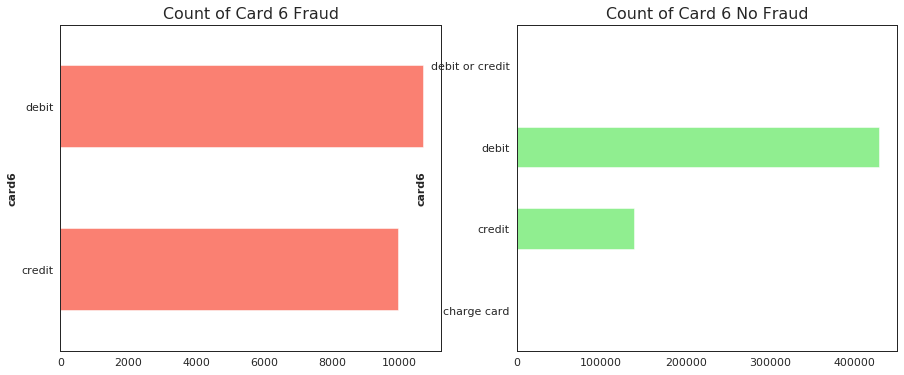

In [0]:
train_fr = train.loc[train['isFraud'] == 1]
train_nofr = train.loc[train['isFraud'] == 0]
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))
train_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax1, title='Count of Card 6 Fraud', color='#FA8072')
train_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax2, title='Count of Card 6 No Fraud', color ='#90EE90')
plt.show()

- Debit or credit and charge card are almost 0% in the dataset.
- Credit card holders tends to have more fraud transaction then debit card holders.

In [0]:
# Lets combine them in to other card category.

def replaceCard(value):
    if value==np.nan:
        return value
    if value=='debit or credit' or value=='charge card':
        return 'debit'
    else:
        return value

In [0]:
train['card6'] = train['card6'].apply(replaceCard)
test['card6'] = test['card6'].apply(replaceCard)

In [0]:
train['isFraud'].groupby(train['card6']).apply(get_stats).unstack()

No Fraud  Fraud     All Fraud(%)
card6                                  
credit   139034   9950  148984    6.68%
debit    429309  10674  439983    2.43%

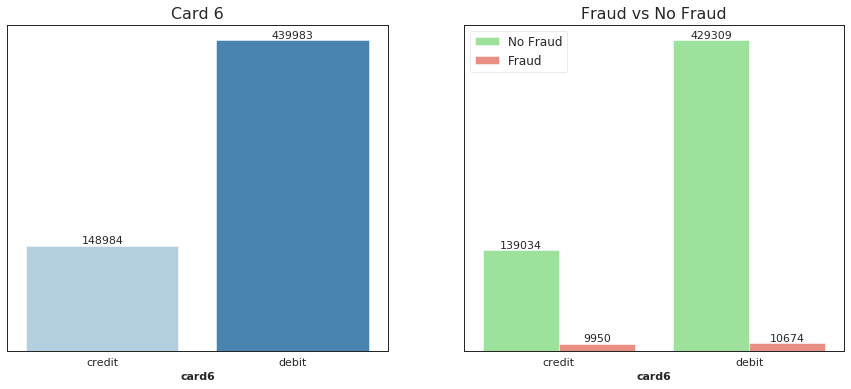

In [0]:
f,ax=plt.subplots(1,2, figsize=(15,6))
cnt= sns.countplot('card6',palette='Blues',data=train, ax=ax[0])
ax[0].set_title('Card 6')
ax[0].set_ylabel('')
ax[0].set_yticklabels('')
text_annotate(cnt)

cnt2 = sns.countplot('card6',hue='isFraud',palette=['#90EE90', '#FA8072'], data=train, ax=ax[1])
ax[1].set_title('Fraud vs No Fraud')
ax[1].legend(['No Fraud','Fraud'])
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
text_annotate(cnt2)

plt.show()

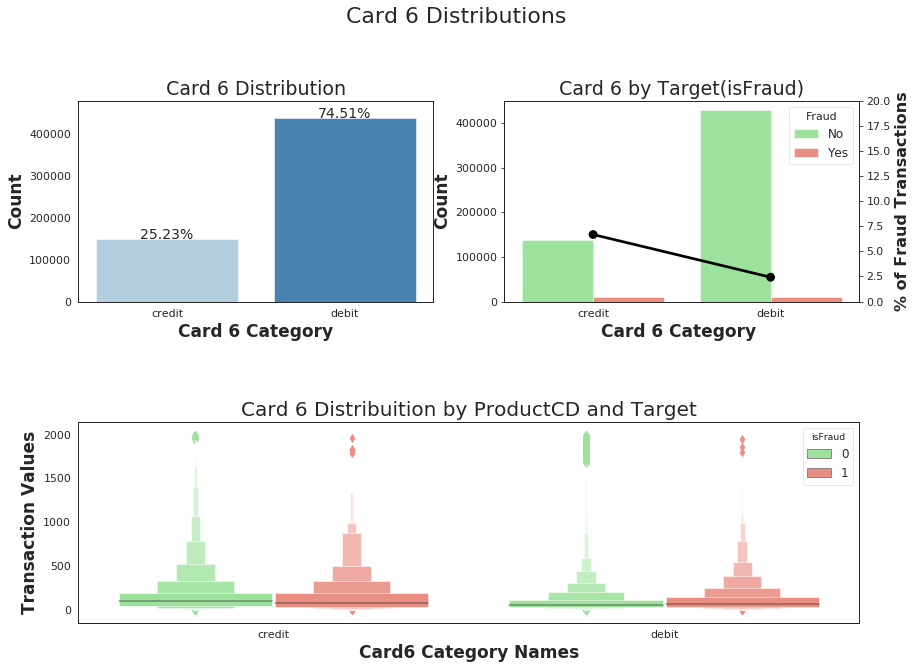

In [0]:
tmp = pd.crosstab(train['card6'], train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card6', data=train, order=list(tmp.card6.values), palette='Blues')
plot_1.set_title("Card 6 Distribution", fontsize=19)
plot_1.set_ylim(0,480000)
plot_1.set_xlabel("Card 6 Category", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='card6', hue='isFraud', data=train, order=list(tmp.card6.values), palette=['#90EE90', '#FA8072'])
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
plot_2_2.set_ylim(0,20)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card 6 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card 6 Category ", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', palette=['#90EE90', '#FA8072'], order=list(tmp.card6.values),
              data=train[train['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card6 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

## Addresses
- **addr1** is the billing region(zip code)
- **addr2** is the billing country

Both the addr is for the purchaser

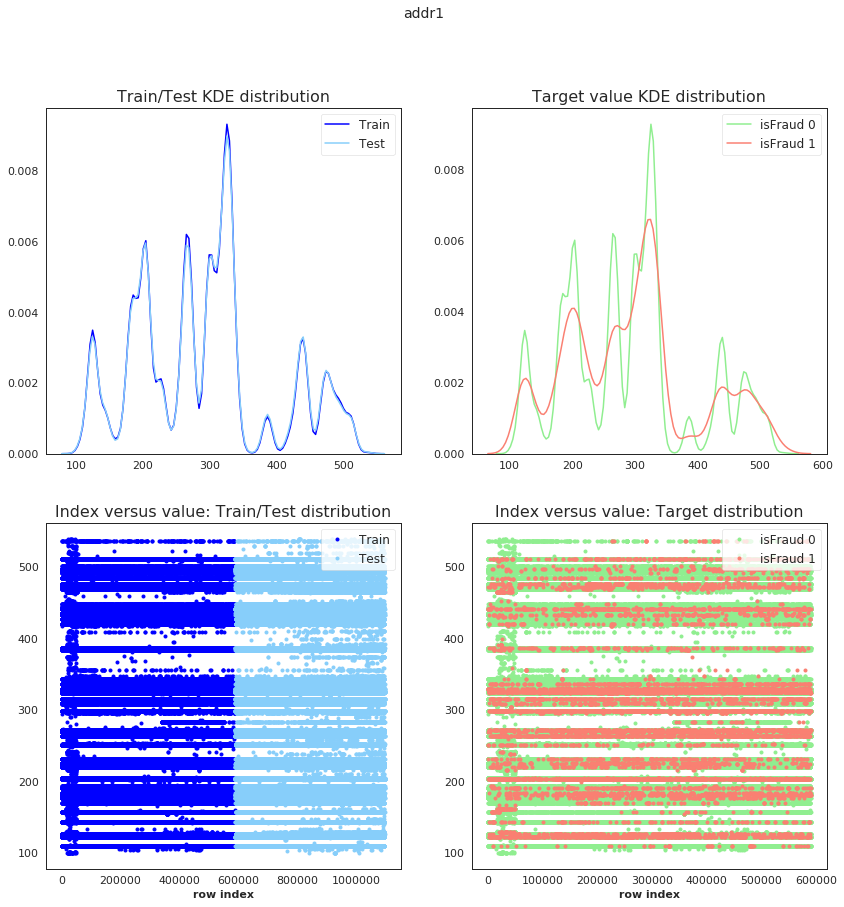

In [10]:
plot_numerical('addr1')

In [0]:
print(' addr1 - has {} NA values'.format(train['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


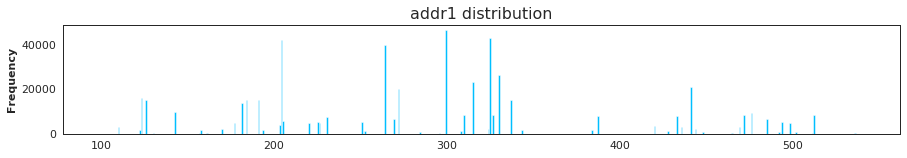

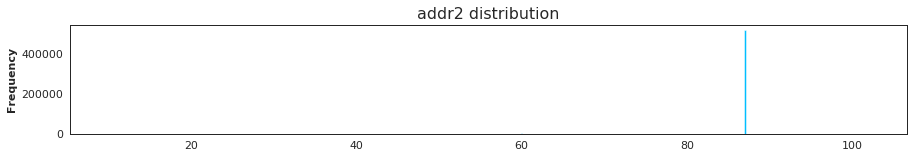

In [0]:
train['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution', color='#00BFFF')
plt.show()
train['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution', color='#00BFFF')
plt.show()

In [0]:
train.loc[train.addr1.isin(train.addr1.value_counts()[train.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train.loc[train.addr2.isin(train.addr2.value_counts()[train.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

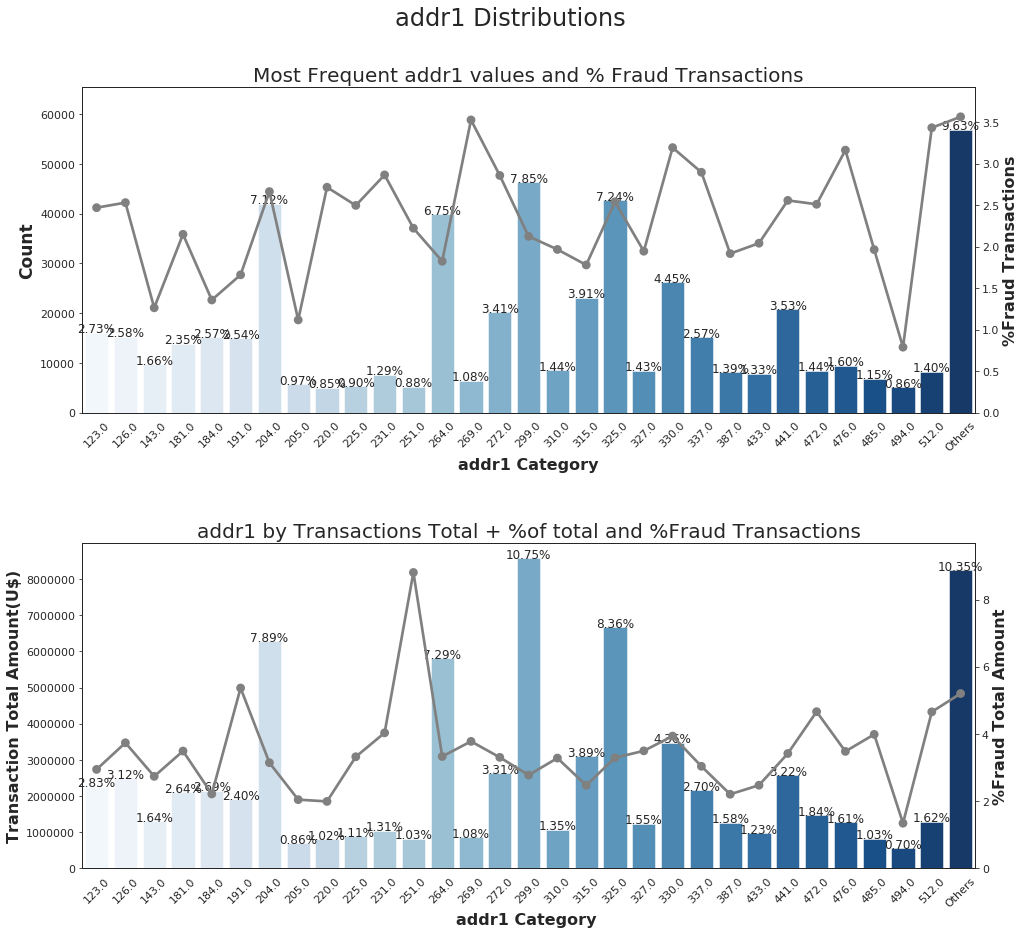

In [0]:
ploting_cnt_amt(train, 'addr1')

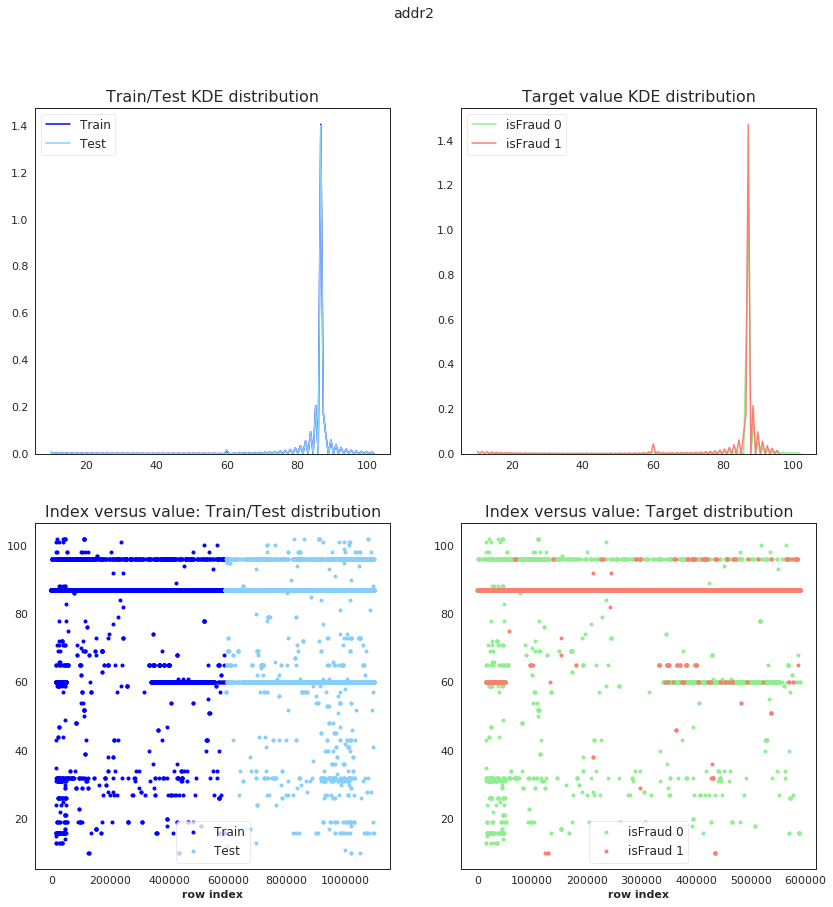

In [11]:
plot_numerical('addr2')

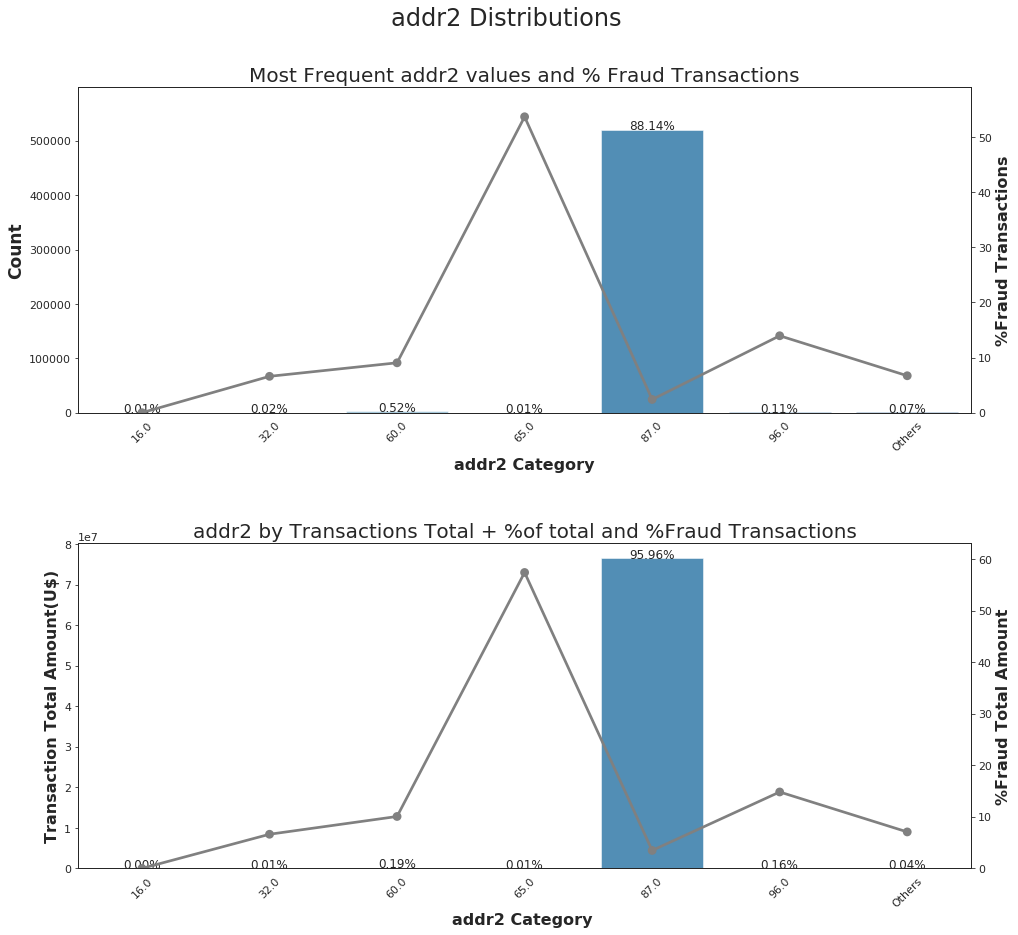

In [0]:
ploting_cnt_amt(train, 'addr2')

## Distances (dist1, dist2)

In [0]:
dist1des = describe(train,test,'dist1')
dist1des

dist1     Train TrainFraud TrainNoFraud      Test
0      count    238267       4755       233512    215474
1       mean   118.503    174.589      117.361   87.0653
2        std   371.873    424.232      370.643   314.132
3        min         0          0            0         0
4        25%         3          3            3         3
5        50%         8         10            8         8
6        75%        24       85.5           24        20
7        max     10286       4942        10286      8081
8     unique      2652        471         2636      1989
9        NaN    352271      15908       336363    291217
10  NaNshare  0.596526   0.769879      0.59024  0.574743

From the mean of TrainFraud it is conclude that fraud transaction have normally larger dist1 then non-fraud transaction.

Text(0.5, 1.0, 'Test')

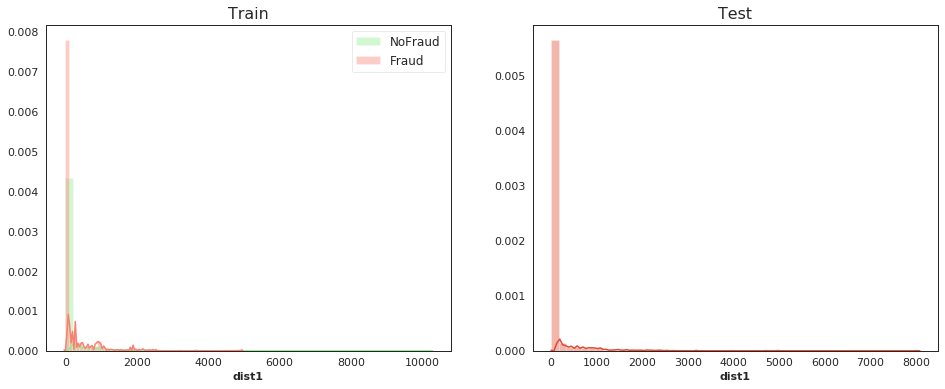

In [0]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.distplot(train[(train['isFraud']==0) & (~train['dist1'].isnull())]['dist1'], color='#90EE90')
sns.distplot(train[(train['isFraud']==1) & (~train['dist1'].isnull())]['dist1'], color='#FA8072')
plt.legend(['NoFraud','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test[~test['dist1'].isnull()]['dist1'])
plt.title('Test')

Text(0.5, 1.0, 'Test')

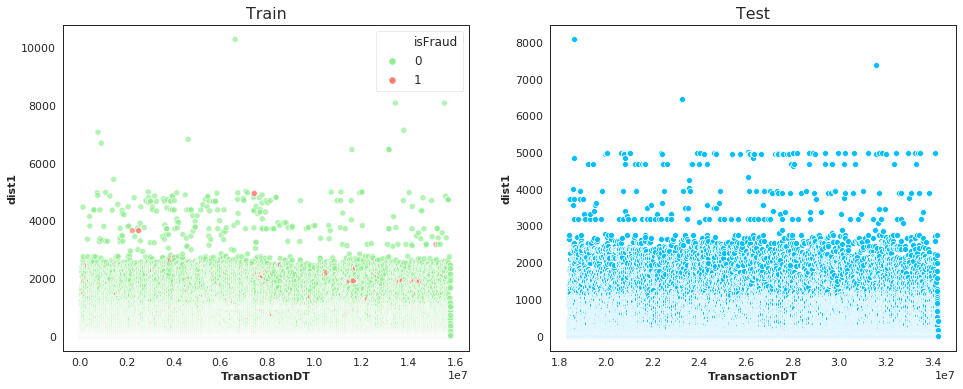

In [0]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="dist1",hue="isFraud",palette=['#90EE90', '#FA8072'], data=train[~train['dist1'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="dist1",data=test[~test['dist1'].isnull()], color='#00BFFF')
plt.title('Test')

We can see some of the outliers in the train data. lets remove all those points whose `dist1 > 6000` in train data

Text(0.5, 1.0, 'Test')

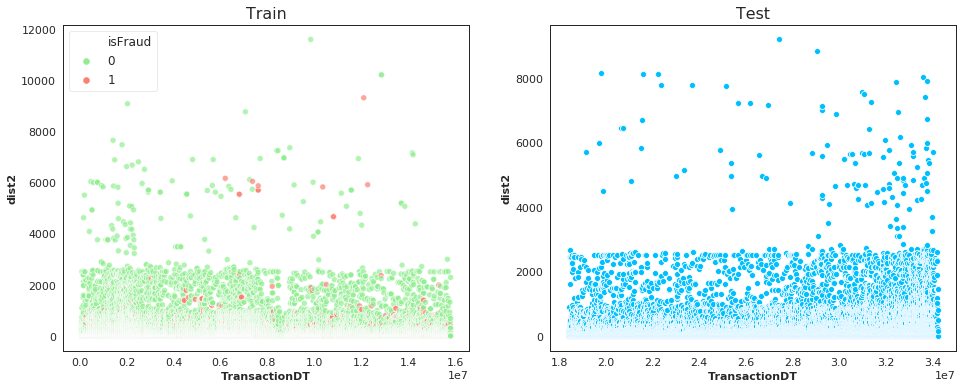

In [0]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="dist2",hue="isFraud",palette=['#90EE90', '#FA8072'],data=train[~train['dist2'].isnull()],alpha=0.7,hue_order=[0,1])
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="dist2",data=test[~test['dist2'].isnull()], color='#00BFFF')
plt.title('Test')

Remove points which have `dist2 > 8000`(these are outliers)

## P_emaildomain

In [0]:
train['isFraud'].groupby(train['P_emaildomain']).apply(get_stats).unstack().sort_values(by='Fraud',ascending=False)

No Fraud Fraud     All Fraud(%)
P_emaildomain                                   
gmail.com          218412  9943  228355    4.35%
hotmail.com         42854  2396   45250    5.30%
yahoo.com           98635  2297  100932    2.28%
anonymous.com       36139   859   36998    2.32%
aol.com             27672   617   28289    2.18%
outlook.com          4614   482    5096    9.46%
comcast.net          7642   246    7888    3.12%
icloud.com           6070   197    6267    3.14%
mail.com              453   106     559   18.96%
msn.com              4002    90    4092    2.20%
live.com             2957    84    3041    2.76%
outlook.es            381    57     438   13.01%
bellsouth.net        1856    53    1909    2.78%
ymail.com            2346    50    2396    2.09%
live.com.mx           708    41     749    5.47%
aim.com               275    40     315   12.70%
protonmail.com         45    31      76   40.79%
att.net              4003    30    4033    0.74%
cox.net              1364    29    1393    2.08%
me.com               1495    27    1522    1.77%
charter.net           791    25     816    3.06%
verizon.net          2683    22    2705    0.81%
hotmail.es            285    20     305    6.56%
optonline.net         994    17    1011    1.68%
yahoo.com.mx         1527    16    1543    1.04%
mac.com               422    14     436    3.21%
sbcglobal.net        2958    12    2970    0.40%
earthlink.net         503    11     514    2.14%
gmail                 485    11     496    2.22%
embarqmail.com        251     9     260    3.46%
frontier.com          272     8     280    2.86%
juno.com              316     6     322    1.86%
yahoo.fr              138     5     143    3.50%
frontiernet.net       190     5     195    2.56%
suddenlink.net        171     4     175    2.29%
roadrunner.com        302     3     305    0.98%
cableone.net          156     3     159    1.89%
rocketmail.com        662     2     664    0.30%
yahoo.es              132     2     134    1.49%
prodigy.net.mx        206     1     207    0.48%
sc.rr.com             163     1     164    0.61%
netzero.net           195     1     196    0.51%
netzero.com           230     0     230    0.00%
yahoo.co.jp            32     0      32    0.00%
gmx.de                149     0     149    0.00%
ptd.net                68     0      68    0.00%
yahoo.de               74     0      74    0.00%
hotmail.co.uk         112     0     112    0.00%
hotmail.de             43     0      43    0.00%
yahoo.co.uk            49     0      49    0.00%
windstream.net        305     0     305    0.00%
live.fr                56     0      56    0.00%
web.de                240     0     240    0.00%
cfl.rr.com            172     0     172    0.00%
twc.com               230     0     230    0.00%
centurylink.net       205     0     205    0.00%
servicios-ta.com       35     0      35    0.00%
q.com                 189     0     189    0.00%
hotmail.fr            295     0     295    0.00%

## R_emaildomain

In [0]:
train['isFraud'].groupby(train['R_emaildomain']).apply(get_stats).unstack().sort_values(by='Fraud',ascending=False)

No Fraud Fraud    All Fraud(%)
R_emaildomain                                  
gmail.com           50336  6811  57147   11.92%
hotmail.com         25369  2140  27509    7.78%
yahoo.com           11232   610  11842    5.15%
anonymous.com       19931   598  20529    2.91%
outlook.com          2093   414   2507   16.51%
icloud.com           1218   180   1398   12.88%
aol.com              3572   129   3701    3.49%
outlook.es            376    57    433   13.16%
mail.com               76    46    122   37.70%
live.com.mx           710    44    754    5.84%
protonmail.com          2    39     41   95.12%
live.com              724    38    762    4.99%
comcast.net          1791    21   1812    1.16%
hotmail.es            272    20    292    6.85%
yahoo.com.mx         1492    16   1508    1.06%
cox.net               448    11    459    2.40%
me.com                545    11    556    1.98%
ymail.com             199     8    207    3.86%
earthlink.net          73     6     79    7.59%
charter.net           122     5    127    3.94%
yahoo.fr              132     5    137    3.65%
rocketmail.com         66     3     69    4.35%
bellsouth.net         420     2    422    0.47%
mac.com               216     2    218    0.92%
yahoo.es               55     2     57    3.51%
netzero.net             7     2      9   22.22%
optonline.net         185     2    187    1.07%
aim.com                35     1     36    2.78%
sbcglobal.net         551     1    552    0.18%
msn.com               851     1    852    0.12%
suddenlink.net         24     1     25    4.00%
prodigy.net.mx        206     1    207    0.48%
twc.com                29     0     29    0.00%
sc.rr.com               8     0      8    0.00%
scranton.edu           63     0     63    0.00%
servicios-ta.com       35     0     35    0.00%
yahoo.de               75     0     75    0.00%
verizon.net           620     0    620    0.00%
att.net               430     0    430    0.00%
windstream.net         47     0     47    0.00%
yahoo.co.jp            33     0     33    0.00%
yahoo.co.uk            39     0     39    0.00%
web.de                237     0    237    0.00%
hotmail.co.uk         105     0    105    0.00%
roadrunner.com         53     0     53    0.00%
q.com                  25     0     25    0.00%
gmx.de                147     0    147    0.00%
cableone.net           27     0     27    0.00%
centurylink.net        12     0     12    0.00%
cfl.rr.com             37     0     37    0.00%
netzero.com            14     0     14    0.00%
live.fr                55     0     55    0.00%
embarqmail.com         68     0     68    0.00%
frontier.com           52     0     52    0.00%
juno.com               53     0     53    0.00%
frontiernet.net        14     0     14    0.00%
hotmail.fr            293     0    293    0.00%
gmail                  95     0     95    0.00%
hotmail.de             42     0     42    0.00%
ptd.net                27     0     27    0.00%

## Device Type

In [0]:
train['isFraud'].groupby(train['DeviceType']).apply(get_stats).unstack().sort_values(by='Fraud',ascending=False)

No Fraud Fraud    All Fraud(%)
DeviceType                               
mobile        49988  5657  55645   10.17%
desktop       79611  5554  85165    6.52%

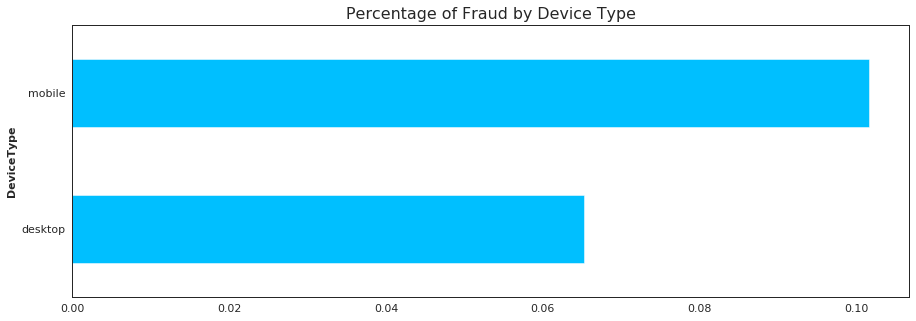

In [0]:
train.groupby('DeviceType').mean()['isFraud'].sort_values().plot(kind='barh',
                                                                 figsize=(15, 5),
                                                                 color='#00BFFF',
                                                                 title='Percentage of Fraud by Device Type')
plt.show()

## Device Info

In [0]:
train['isFraud'].groupby(train['DeviceInfo']).apply(get_stats).unstack().sort_values(by='Fraud(%)',ascending=False).head(20)

No Fraud Fraud  All Fraud(%)
DeviceInfo                                                      
hi6210sft Build/MRA58K                    10   180  190   94.74%
TR10CS1 Build/JDQ39                        1    10   11   90.91%
Lenovo YT3-850M Build/MMB29M               1    10   11   90.91%
Hisense F23 Build/NRD90M                  55     6   61    9.84%
5056A Build/MMB29M                        28     3   31    9.68%
SM-N900W8 Build/LRX21V                    19     2   21    9.52%
rv:60.0                                   57     6   63    9.52%
Android 5.1                               29     3   32    9.38%
SM-J500M Build/MMB29M                     39     4   43    9.30%
ALE-L23 Build/HuaweiALE-L23              283    29  312    9.29%
SM-G935F Build/NRD90M                    303    31  334    9.28%
Blade V6 Plus Build/MRA58K                69     7   76    9.21%
M4 SS4457 Build/MRA58K                    10     1   11    9.09%
SM-J730G Build/NRD90M                     10     1   11    9.09%
MotoG3-TE Build/MPDS24.65-33-1-3           1     8    9   88.89%
LG-D320 Build/KOT49I.V10a                 10    61   71   85.92%
TA-1039 Build/NMF26F                       5    27   32   84.38%
Moto Z2 Play Build/NPSS26.118-19-11        2    10   12   83.33%
Alcatel_4060O Build/MMB29M                 1     5    6   83.33%
Ilium Pad T7X Build/LMY47I                 1     5    6   83.33%

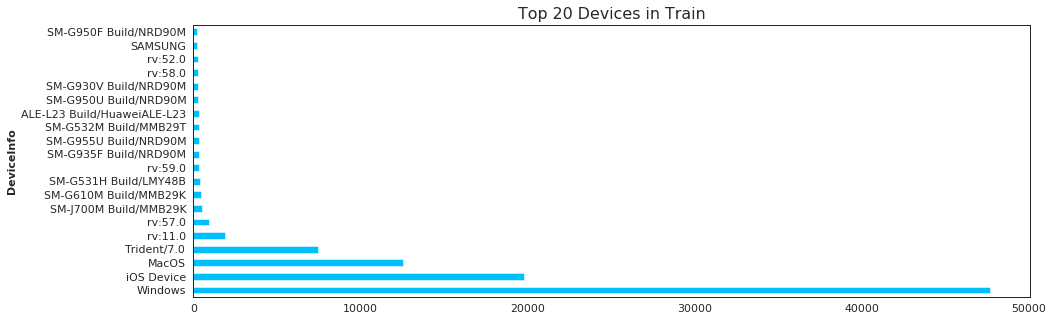

In [0]:
train.groupby('DeviceInfo').count()['TransactionID'].sort_values(ascending=False).head(20).plot(kind='barh', 
                                                                                                color='#00BFFF', 
                                                                                                figsize=(15, 5), 
                                                                                                title='Top 20 Devices in Train')
plt.show()

## Analysis on id_23 (IP Proxy)

In [0]:
train['isFraud'].groupby(train['id_23']).apply(get_stats).unstack()

No Fraud Fraud   All Fraud(%)
id_23                                             
IP_PROXY:ANONYMOUS        924   147  1071   13.73%
IP_PROXY:HIDDEN           575    34   609    5.58%
IP_PROXY:TRANSPARENT     3244   245  3489    7.02%

## Analysis on id_30 features (Operating System)

In [0]:
train['isFraud'].groupby(train['id_30']).apply(get_stats).unstack().sort_values(by='Fraud(%)',ascending=False).head(20)

No Fraud Fraud   All Fraud(%)
id_30                                         
Windows Vista         223    23   246    9.35%
iOS 11.0.0            131    13   144    9.03%
iOS 10.2.1            260    25   285    8.77%
Android 6.0.1         518    48   566    8.48%
iOS 11.2.0            780    72   852    8.45%
iOS 10.2.0            137    12   149    8.05%
iOS 11.0.2            153    13   166    7.83%
Linux                1051    85  1136    7.48%
iOS 11.1.1            651    49   700    7.00%
other                   6     9    15   60.00%
Windows 8.1          1781   133  1914    6.95%
iOS 11.3.0           1878   138  2016    6.85%
iOS 10.3.2            399    29   428    6.78%
iOS 10.0.2             89     6    95    6.32%
Mac OS X 10_11_5       77     5    82    6.10%
Mac OS X 10_9_5       536    34   570    5.96%
iOS 10.3.1            222    14   236    5.93%
Android 7.0          2705   166  2871    5.78%
iOS 11.2.6           1553    94  1647    5.71%
iOS 10.3.3           1469    89  1558    5.71%

#Analysis on id_31 features (Browser)


In [0]:
train['isFraud'].groupby(train['id_31']).apply(get_stats).unstack().sort_values(by='Fraud(%)',ascending=False).head(20)

No Fraud Fraud    All Fraud(%)
id_31                                                 
mobile safari generic      10328  1146  11474    9.99%
chrome 60.0                  334    37    371    9.97%
chrome 65.0                 6192   679   6871    9.88%
chrome 66.0                 3866   398   4264    9.33%
chrome 55.0 for android      274    28    302    9.27%
firefox 58.0                 756    77    833    9.24%
chrome 64.0                 6096   615   6711    9.16%
firefox 60.0                 206    19    225    8.44%
google                        33     3     36    8.33%
firefox 47.0                  34     3     37    8.11%
chrome                       394    34    428    7.94%
firefox 59.0                1013    86   1099    7.83%
chrome 62.0 for android     1936   161   2097    7.68%
samsung browser 6.4          470    39    509    7.66%
mobile safari uiwebview       90     7     97    7.22%
samsung browser 6.2          986    75   1061    7.07%
Lanix/Ilium                    1     2      3   66.67%
comodo                         2     4      6   66.67%
samsung browser 7.0           94     7    101    6.93%
chrome 63.0                20497  1503  22000    6.83%

## Analysis on id_33 features (Screen Resolution)

In [0]:
train['isFraud'].groupby(train['id_33']).apply(get_stats).unstack().sort_values(by='Fraud',ascending=False).head(20)

No Fraud Fraud    All Fraud(%)
id_33                                   
1366x768      8112   493   8605    5.73%
1920x1080    16384   490  16874    2.90%
2208x1242     4418   482   4900    9.84%
1334x750      6066   381   6447    5.91%
1280x720      1137   181   1318   13.73%
2436x1125     1316   168   1484   11.32%
1440x900      4256   128   4384    2.92%
1600x900      3397   113   3510    3.22%
1280x800      2046   103   2149    4.79%
855x480        155    95    250   38.00%
1136x640      1644    68   1712    3.97%
2048x1536     3417    65   3482    1.87%
2001x1125      959    61   1020    5.98%
1024x600        31    57     88   64.77%
1280x1024     1690    53   1743    3.04%
2560x1600     2050    43   2093    2.05%
1024x768       790    34    824    4.13%
2220x1080      515    29    544    5.33%
2880x1800     1727    29   1756    1.65%
1680x1050     1701    26   1727    1.51%

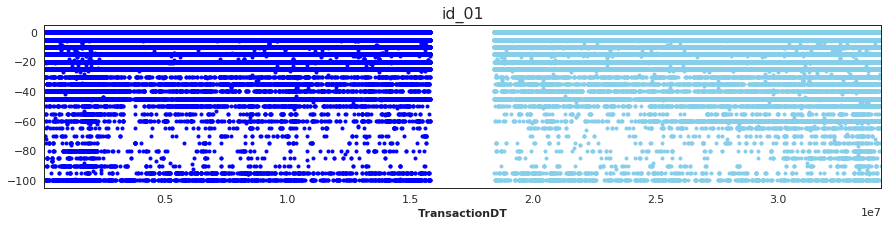

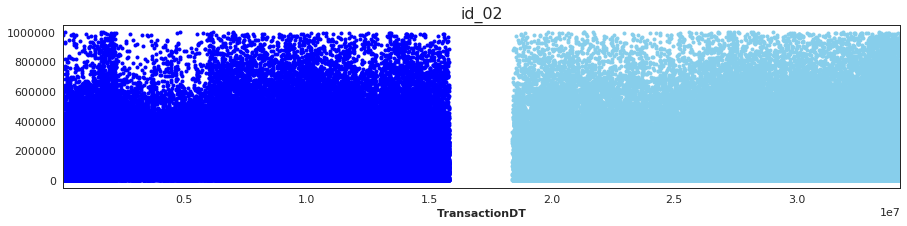

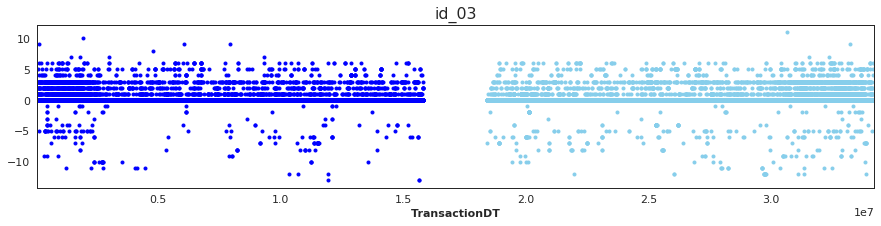

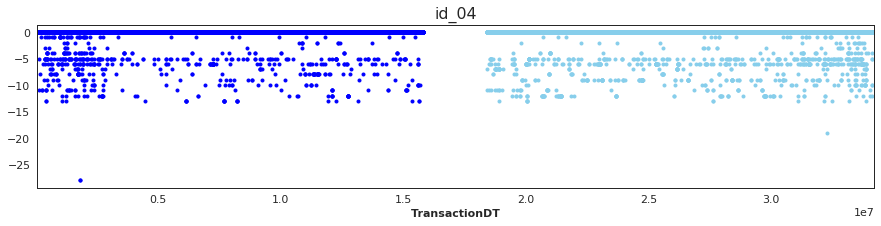

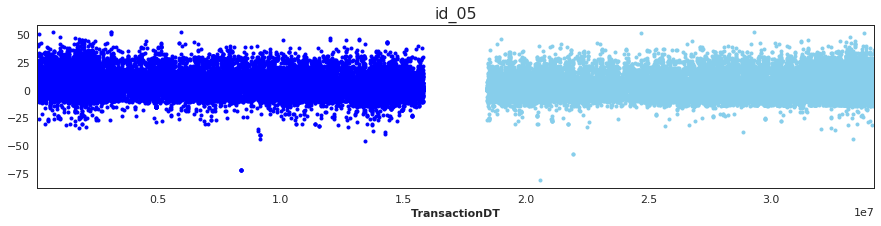

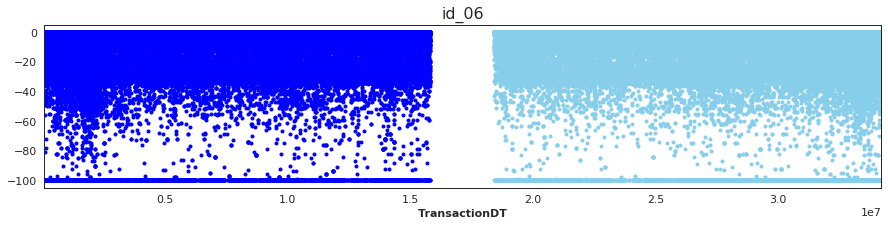

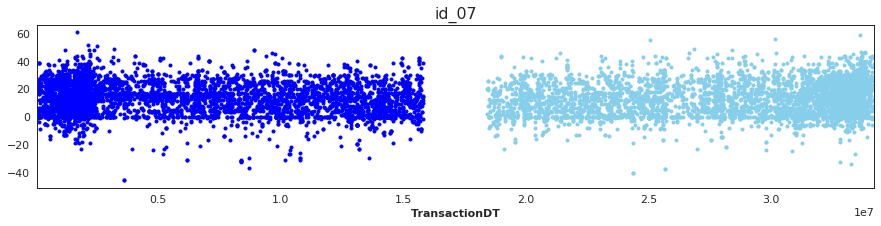

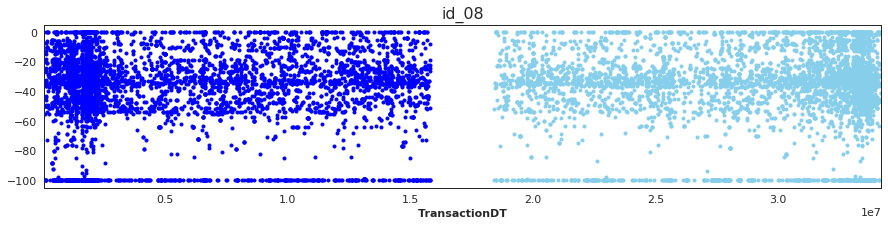

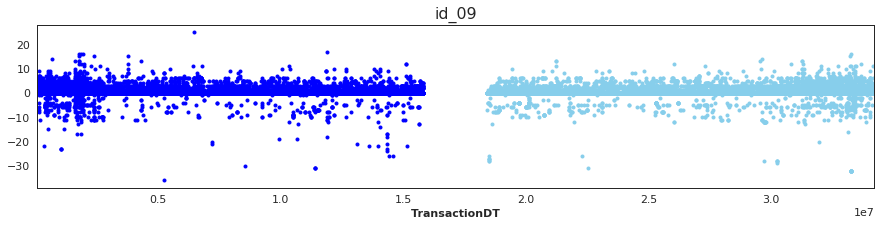

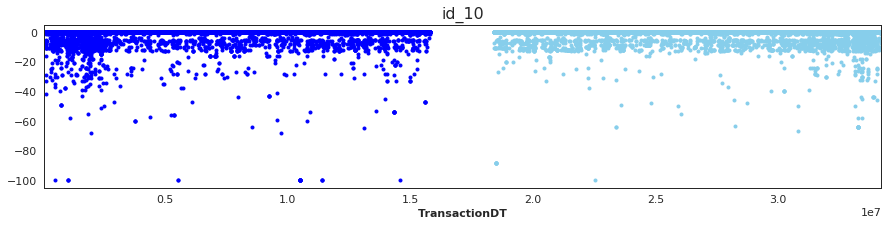

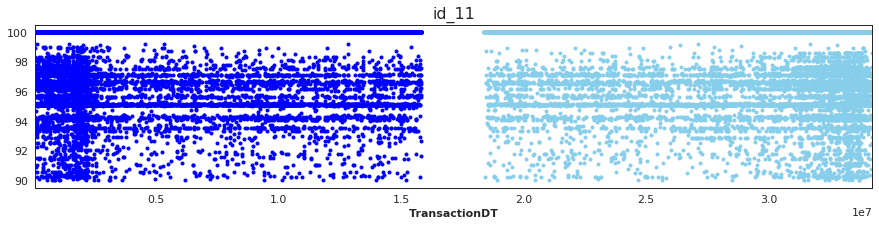

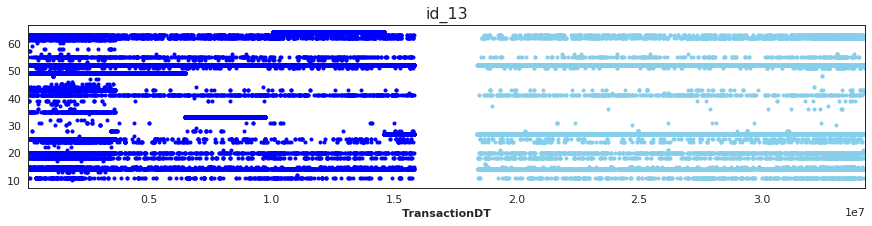

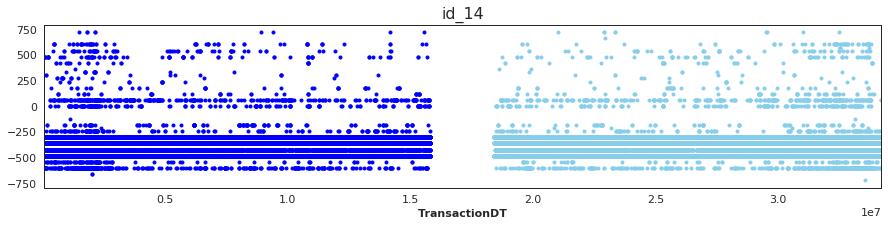

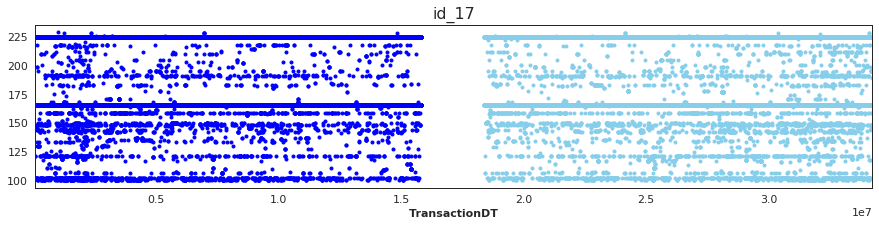

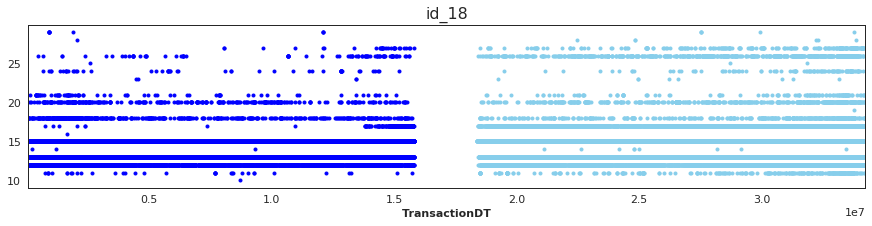

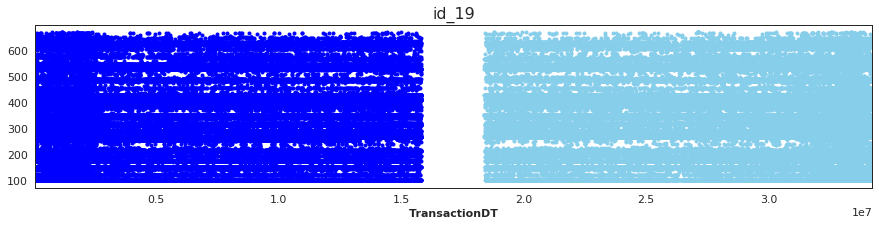

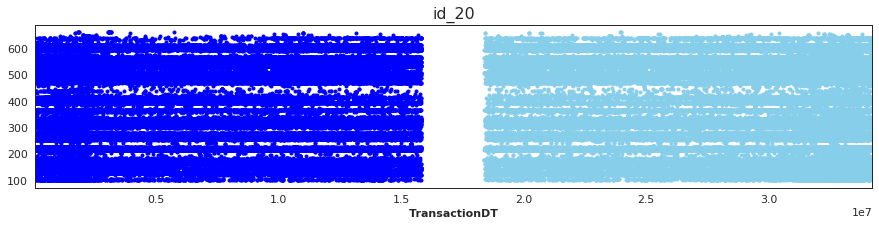

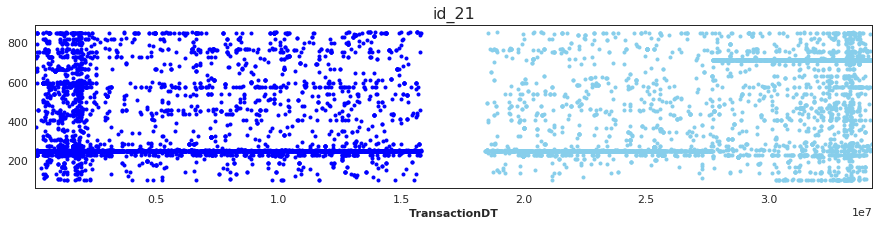

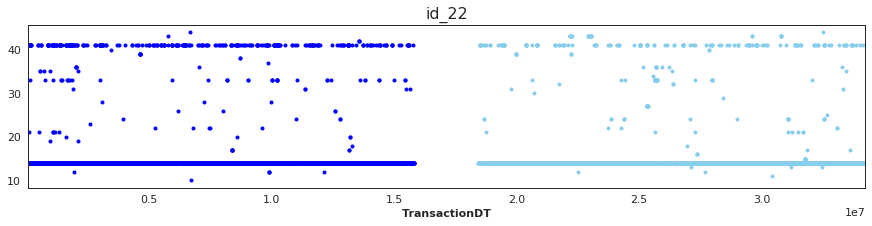

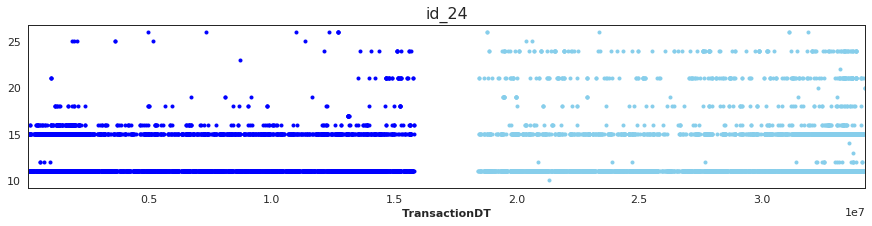

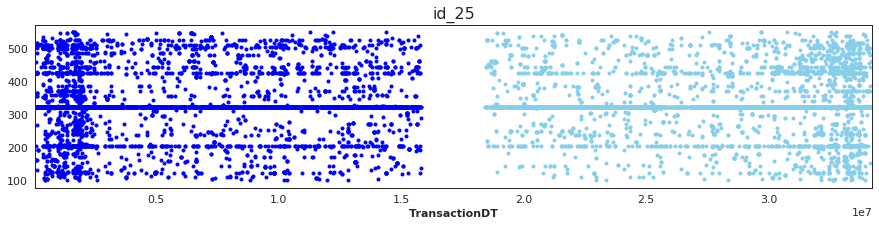

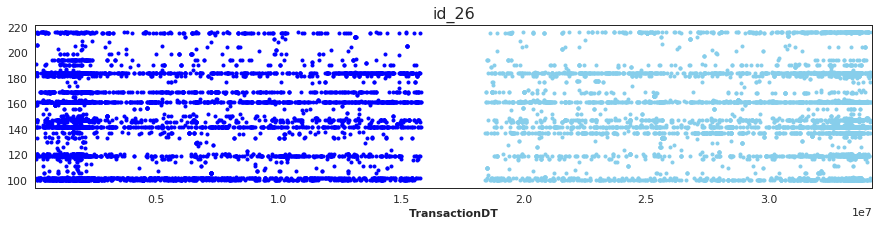

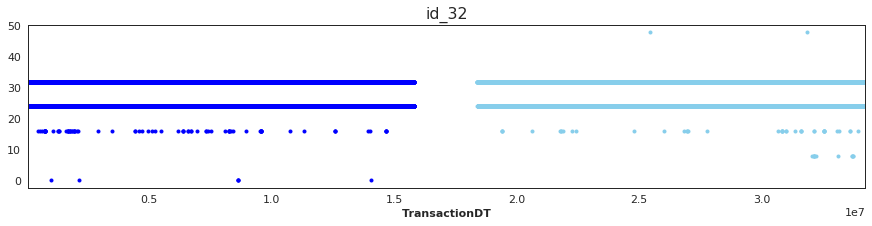

In [18]:
id_cols = [c for c in train.columns if 'id' in c]
for i in id_cols:
    try:
        train.set_index('TransactionDT')[i].plot(style='.', color='b', title=i, figsize=(15, 3))
        test.set_index('TransactionDT')[i].plot(style='.', color='skyblue', title=i, figsize=(15, 3))
        plt.show()
    except TypeError:
        pass